In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import argparse
import matplotlib.pyplot as plt
import albumentations
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils
import torch
import torch.nn.functional as F
from tqdm import tqdm as tqdm
import sys
from torch.utils.data import DataLoader
import math
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import glob
import rasterio
import json
import re
import shutil
import random

C:\Users\CITY3\.conda\envs\pgsegenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
## Spliting Data intro train and test


path_to_images = r'C:\Users\CITY3\Desktop\PD-Seg Work\Dataset wo new markings\TS 1024 wo new markings\raster images\*\*.png'
seed_value = 230
split = 0.8    # The ratio for train part
output_dir = r'C:\Users\CITY3\Desktop\PD-Seg Work\Dataset wo new markings\Our_Segmentation_Data_TS_1024'

train_imgs_dir = os.path.join(output_dir,'train/images')
train_msks_dir = os.path.join(output_dir,'train/masks')
test_imgs_dir = os.path.join(output_dir,'test/images')
test_msks_dir = os.path.join(output_dir,'test/masks')

if not os.path.exists(train_imgs_dir):
    os.makedirs(train_imgs_dir)
    
if not os.path.exists(train_msks_dir):
    os.makedirs(train_msks_dir)
    
if not os.path.exists(test_imgs_dir):
    os.makedirs(test_imgs_dir)
    
if not os.path.exists(test_msks_dir):
    os.makedirs(test_msks_dir)

images = glob.glob(path_to_images)
images.sort()
# print(images[0])
random.seed(seed_value)
random.shuffle(images)
# print(images[0])

train_index = int(split * len(images))
train_images = images[:train_index]

for i,image in enumerate(train_images):
    src_path = image
    dst_path = os.path.join(train_imgs_dir,'{}.png'.format(i))
    shutil.copy(src_path, dst_path)
    src_path = image.replace('raster images', 'marking images').replace('.png', '.npy')
    dst_path = os.path.join(train_msks_dir,'{}.npy'.format(i))
    shutil.copy(src_path, dst_path)
    

test_images = images[train_index:]
for i,image in enumerate(test_images):
    src_path = image
    dst_path = os.path.join(test_imgs_dir,'{}.png'.format(i))
    shutil.copy(src_path, dst_path)
    src_path = image.replace('raster images', 'marking images').replace('.png', '.npy')
    dst_path = os.path.join(test_msks_dir,'{}.npy'.format(i))
    shutil.copy(src_path, dst_path)

In [4]:
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

In [5]:
# classes for data loading and preprocessing
class Dataset:
    """ Dataset Classs. Read images, apply augmentation and preprocessing transformations.

    Args:
        base_dir (str): path to base folder
        classes (list): classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. normalization, shape manipulation, etc.)
        size (int): size needed for image
        db (str): name of database/dataset to use
        train (bool): Load training or testing (valid) portion
    """

    CLASSES = ['built-up', 'background']
    def __init__(
            self,
            base_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
            size=1024,
            train=True,
            split=0.8,
            seed_value=2022
    ):
        # assert self.train is not None, "Pass the train argument data"
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.size = size
        self.train = train
        
#         path_to_imgs = base_dir + "/test/images/*.png"
        path_to_imgs = base_dir + "/train/images/*.png"
        image_ids = glob.glob(path_to_imgs)
        np.random.seed(seed_value)
        image_ids = np.random.permutation(image_ids)
        mask_paths = [image_id.replace(".png", ".npy").replace("images", "masks") for image_id in image_ids]
        length = len(image_ids)
        if self.train:
            self.image_paths = image_ids[:int(split * length)]
            self.mask_paths = mask_paths[:int(split * length)]
        else:
            self.image_paths = image_ids[int(split * length):]
            self.mask_paths = mask_paths[int(split * length):]

    def __getitem__(self, i):

        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = np.load(os.path.join(self.mask_paths[i]))
        mask = (mask > 0).astype(np.int32)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        image = cv2.resize(image, (self.size, self.size), interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask.astype('uint8'), (self.size, self.size), interpolation=cv2.INTER_AREA)

        # print("Mask Shape after process 4: {}".format(mask.shape))
        image = np.transpose(image, (2, 0, 1)).astype('float32')

        return image, mask, self.image_paths[i]

    def __len__(self):
        return len(self.image_paths)

In [6]:
#////////////////////////Augmentations\\\\\\\\\\\\\\\\\\\\\\\\
def get_training_augmentation(size=1024):
    train_transform = [albumentations.HorizontalFlip(p=0.5),
#         albumentations.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
        albumentations.PadIfNeeded(min_height=size, min_width=size, always_apply=True, border_mode=0),
        #albumentations.RandomCrop(height=320, width=320, always_apply=True),
        albumentations.GaussNoise(p=0.2),
        albumentations.IAAPerspective(p=0.5),
        albumentations.OneOf(
            [
                albumentations.CLAHE(p=1),
                albumentations.RandomBrightness(p=1),
                albumentations.RandomGamma(p=1),
            ],
            p=0.5,
        ),
        albumentations.OneOf(
            [
                albumentations.Sharpen(p=1),
                albumentations.Blur(blur_limit=3, p=1),
                albumentations.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.5,
        ),
        albumentations.OneOf(
            [
                albumentations.RandomContrast(p=1),
                albumentations.HueSaturationValue(p=1),
            ],
            p=0.5,
        ),
        albumentations.Lambda(mask=round_clip_0_1)
    ]
    
    return albumentations.Compose(train_transform)

def get_validation_augmentation(size=1024):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albumentations.PadIfNeeded(size, size)
    ]
    return albumentations.Compose(test_transform)

In [7]:
#////////////////////////Pre Processing\\\\\\\\\\\\\\\\\\\\\\\\
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albumentations.Lambda(image=preprocessing_fn),
    ]
    return albumentations.Compose(_transform)

In [50]:
#//////////////////////// Setting the parameters \\\\\\\\\\\\\\\\\\\\\\\\
data_dir = r'C:\Users\CITY3\Desktop\PD-Seg Work\Dataset wo new markings\Our_Segmentation_Data_TS_1024' # Path to Dataset
output_dir = r'C:\Users\CITY3\Desktop\PD-Seg Work\Models\wo new markings\built_vs_unbuilt_DL_TS_1024' # Path to save model
CLASSES = ['built-up']
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)
BACKBONE = "efficientnetb3"
BATCH_SIZE_TRAIN = 8
BATCH_SIZE_VAL = 1
LR = 0.0001
EPOCHS = 100
mode = 'binary' if len(CLASSES) == 1 else 'multiclass'
mode_choices = ['binary', 'multiclass', 'multilabel'] #See documentation for more details.
threshold = 0.5 #Threshold for computation of tp,fp,fn,tn
_lambda = 1

print(mode)

assert (mode in mode_choices), "Mode can be only from one of these: {}".format(mode_choices)
#Define Network/ Models and it's parameters. See documentation for more details.
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' if n_classes == 1 else 'softmax2D' # could be None for logits or 'softmax2d' for multiclass segmentation
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=n_classes, 
    activation=ACTIVATION
    )
# print(model)

#Pre-processing function to pre-process whole data for encoder
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=LR),
])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=0.00005,
    )

'''
Define Loss function. See smp.losses for more details:
Types required are as follows:
Ground Truth : torch.tensor of shape(N,1,H,W) for binary mode, (N,H,W) for multiclass mode and (N,C,H,W) 
               for multilabel mode.
Prediction : (N,1,H,W) for binary mode, (N,C,H,W) for multiclass mode and multilabel mode.

To see details of mode, see documentation of smp library.
'''
# focal_loss = smp.losses.FocalLoss(mode)
#jacc_loss = smp_utils.losses.JaccardLoss()

# dice_loss = smp_utils.losses.DiceLoss()
dice_loss = smp.losses.DiceLoss(mode)

loss =  dice_loss #(_lambda * jacc_loss)

#Define metrics to compute
metrics = {"IOU Score": smp.metrics.iou_score,
           "F1 Score": smp.metrics.f1_score,
           "F_beta score": smp.metrics.fbeta_score,
           "Accuracy": smp.metrics.accuracy,
           "Recall": smp.metrics.recall}

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

binary
cuda


uint8
(1024, 1024, 3)
(1024, 1024)


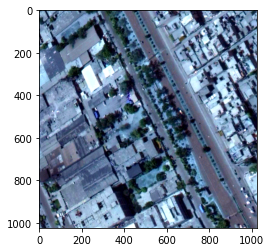

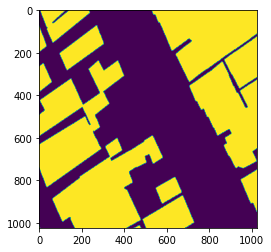

In [12]:
#//////////////////////// Visualize the data \\\\\\\\\\\\\\\\\\\\\\\\
imgs_dir = os.path.join(data_dir, 'train\images')
msks_dir = os.path.join(data_dir, 'train\masks')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = Dataset(
            data_dir,
            classes=CLASSES,
            augmentation=get_training_augmentation(size=1024),
            preprocessing=get_preprocessing(preprocessing_fn),
            train=True,
            size=1024
        )

image, mask, _ = dataset[200]
image = denormalize(np.transpose(image,(1,2,0)))
print(mask.dtype)
print(image.shape)
print(mask.shape)
plt.imshow(image)
plt.show()
plt.imshow(mask)
plt.show()

In [13]:
#//////////////////////// Training \\\\\\\\\\\\\\\\\\\\\\\\
ct_train = False
overwrite = False

if ct_train:
    assert os.path.exists(os.path.join(output_dir,'best_model.h5')), "Model not found at path: {}".format(output_dir)
    model = torch.load(os.path.join(output_dir,'best_model.h5'), map_location=DEVICE)
    print('Loaded pre-trained DeepLabV3+ model!')
else:
    if os.path.exists(os.path.join(output_dir,'best_model.h5')):
        assert (overwrite), "Path already exists, cannot over write. Please set the overwrite flag to high,\
        if you want to overwrite"
        print("Warining Model path {} already exists, overwriting it".format(output_dir))
    else:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
    
model.to(DEVICE)
# Dataset for train images
train_dataset = Dataset(
    data_dir,
    classes=CLASSES,
    augmentation=get_training_augmentation(size=1024),
    preprocessing=get_preprocessing(preprocessing_fn),
    train=True,
    size=1024
)
# Dataset for validation images
valid_dataset = Dataset(
    data_dir,
    classes=CLASSES,
    augmentation=get_validation_augmentation(size=1024),
    preprocessing=get_preprocessing(preprocessing_fn),
    train=False,
    size=1024
)
threshold = 0.5 #Threshold for computation of tp,fp,fn,tn


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE_VAL, shuffle=False, num_workers=0)

best_iou_score = 0.0

if ct_train:
    f = open(os.path.join(output_dir, 'train_logs.txt'), "r")
    lines = f.readlines()
    f.close()
    if len(lines) > 1:
        start = int(lines[-1].split(' ')[0]) + 1
    else:
        start =0
    
    print("Starting from Epoch {}".format(start))
else:
    with open(os.path.join(output_dir, 'train_logs.txt'), "w") as f:
        f.write("Epoch #: Logs" + "\n")

    with open(os.path.join(output_dir, 'valid_logs.txt'), "w") as f:
        f.write("Epoch #: Logs" + "\n")
    
    start = 0
    
print("Total Epochs: {}".format(EPOCHS))
for i in range(start, EPOCHS):
    # Perform training & validation
    print('\nEpoch: {}'.format(i))
    model.train()
    train_logs = {}
    loss_meter = np.array([])
    metrics_meters = {name: np.array([]) for name, func in metrics.items()}
    verbose = True
#     iter_inst = next(iter(train_loader))

    with tqdm(train_loader) as iterator:
#         iter_inst = next(iter(train_loader))
#         while iter_inst is not None:
        for x, y, _ in iterator:
#             iter_inst = next(train_loader)
#             if iter_inst is None:
#                 break
#             x, y, _ = iter_inst
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            y_pred = model.forward(x)
            loss_Val = loss(y_pred, y)
            loss_Val.backward()
            optimizer.step()
            # update loss logs
            loss_value = loss_Val.cpu().detach().numpy()
            loss_meter = np.append(loss_meter, loss_value)
            loss_logs = {"LOSS": np.mean(loss_meter)}
            train_logs.update(loss_logs)

            if mode == mode_choices[2]:
                tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(y_pred, dim=1), y, mode=mode,
                                                       threshold=threshold)
            elif mode == mode_choices[1]:
                tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(y_pred, dim=1), y, mode=mode,
                                                       num_classes=n_classes)
            elif mode == mode_choices[0]:
                tp, fp, fn, tn = smp.metrics.get_stats(torch.squeeze(y_pred, dim=1), y, mode=mode,
                                                       threshold=threshold)

            # update metrics logs
            for name, metric_fn in metrics.items():
                metric_value = metric_fn(tp, fp, fn, tn).cpu().detach().numpy()
                metrics_meter = metrics_meters[name]
                metrics_meters[name] = np.append(metrics_meter, metric_value)

            metrics_logs = {name: np.mean(values) for name, values in metrics_meters.items()}
            train_logs.update(metrics_logs)

            if verbose:
                str_logs = ['{} - {:.4}'.format(k, v) for k, v in train_logs.items()]
                s = ', '.join(str_logs)
                iterator.set_postfix_str(s)
            
#             iter_inst = next(iterator)

    torch.save(model, os.path.join(output_dir, 'current_model.h5'))

    with open(os.path.join(output_dir, 'train_logs.txt'), 'a') as f:
        f.write("{} : {}".format(i, str(train_logs)) + "\n")

    model.eval()
    valid_logs = {}
    loss_meter = np.array([])
    metrics_meters = {name: np.array([]) for name, func in metrics.items()}
    verbose = True

    with tqdm(valid_loader, desc="Valid", file=sys.stdout, disable=not verbose) as iterator:
        for x, y, _ in iterator:
            x, y = x.to(DEVICE), y.to(DEVICE)
            with torch.no_grad():
                y_pred = model.forward(x)
                loss_Val = loss(y_pred, y)

            # update loss logs
            loss_value = loss_Val.cpu().detach().numpy()
            loss_meter = np.append(loss_meter, loss_value)
            loss_logs = {"LOSS": np.mean(loss_meter)}
            valid_logs.update(loss_logs)

            if mode == mode_choices[2]:
                tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(y_pred, dim=1), y, mode=mode,
                                                       threshold=threshold)
            elif mode == mode_choices[1]:
                tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(y_pred, dim=1), y, mode=mode,
                                                       num_classes=n_classes)
            elif mode == mode_choices[0]:
                tp, fp, fn, tn = smp.metrics.get_stats(torch.squeeze(y_pred, dim=1), y, mode=mode,
                                                       threshold=threshold)

            # update metrics logs
            for name, metric_fn in metrics.items():
                metric_value = metric_fn(tp, fp, fn, tn).cpu().detach().numpy()
                metrics_meter = metrics_meters[name]
                metrics_meters[name] = np.append(metrics_meter, metric_value)

            metrics_logs = {name: np.mean(vals) for name, vals in metrics_meters.items()}
            valid_logs.update(metrics_logs)

            if verbose:
                str_logs = ['{} - {:.4}'.format(k, v) for k, v in valid_logs.items()]
                s = ', '.join(str_logs)
                iterator.set_postfix_str(s)

    with open(os.path.join(output_dir, 'valid_logs.txt'), 'a') as f:
        f.write("{} : {}".format(i, str(valid_logs)) + "\n")

    curr_miou = valid_logs['IOU Score']
    if curr_miou > best_iou_score:
        best_iou_score = curr_miou
        print("Current miou {} is better, updating best model".format(best_iou_score))
        torch.save(model, os.path.join(output_dir, 'best_model.h5'))

Total Epochs: 100

Epoch: 0


100%|█| 228/228 [05:49<00:00,  1.53s/it, LOSS - 0.6306, IOU Score - 0.6297, F1 Score - 0.697, F_beta score - 0.697, Acc


Valid: 100%|█| 456/456 [00:58<00:00,  7.75it/s, LOSS - 0.5161, IOU Score - 0.6967, F1 Score - 0.7673, F_beta score - 0.
Current miou 0.6967299877024966 is better, updating best model

Epoch: 1


100%|█| 228/228 [05:39<00:00,  1.49s/it, LOSS - 0.6204, IOU Score - 0.7042, F1 Score - 0.7669, F_beta score - 0.7669, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.80it/s, LOSS - 0.514, IOU Score - 0.7279, F1 Score - 0.7946, F_beta score - 0.7
Current miou 0.7279205751674488 is better, updating best model

Epoch: 2


100%|█| 228/228 [05:49<00:00,  1.53s/it, LOSS - 0.6199, IOU Score - 0.729, F1 Score - 0.7886, F_beta score - 0.7886, Ac


Valid: 100%|█| 456/456 [00:58<00:00,  7.76it/s, LOSS - 0.5121, IOU Score - 0.7542, F1 Score - 0.8146, F_beta score - 0.
Current miou 0.7541700982077904 is better, updating best model

Epoch: 3


100%|█| 228/228 [05:33<00:00,  1.46s/it, LOSS - 0.6194, IOU Score - 0.7377, F1 Score - 0.7964, F_beta score - 0.7964, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.81it/s, LOSS - 0.5118, IOU Score - 0.7519, F1 Score - 0.8119, F_beta score - 0.

Epoch: 4


100%|█| 228/228 [05:39<00:00,  1.49s/it, LOSS - 0.6185, IOU Score - 0.7443, F1 Score - 0.8018, F_beta score - 0.8018, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.80it/s, LOSS - 0.5121, IOU Score - 0.7672, F1 Score - 0.8247, F_beta score - 0.
Current miou 0.7672202161727347 is better, updating best model

Epoch: 5


100%|█| 228/228 [05:42<00:00,  1.50s/it, LOSS - 0.6192, IOU Score - 0.7467, F1 Score - 0.8042, F_beta score - 0.8042, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.88it/s, LOSS - 0.5117, IOU Score - 0.752, F1 Score - 0.8135, F_beta score - 0.8

Epoch: 6


100%|█| 228/228 [05:34<00:00,  1.47s/it, LOSS - 0.619, IOU Score - 0.7523, F1 Score - 0.8088, F_beta score - 0.8088, Ac


Valid: 100%|█| 456/456 [00:57<00:00,  7.87it/s, LOSS - 0.5116, IOU Score - 0.744, F1 Score - 0.8064, F_beta score - 0.8

Epoch: 7


100%|█| 228/228 [05:34<00:00,  1.47s/it, LOSS - 0.6171, IOU Score - 0.7565, F1 Score - 0.8128, F_beta score - 0.8128, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.89it/s, LOSS - 0.5112, IOU Score - 0.7709, F1 Score - 0.828, F_beta score - 0.8
Current miou 0.7708937045251757 is better, updating best model

Epoch: 8


100%|█| 228/228 [05:38<00:00,  1.48s/it, LOSS - 0.6175, IOU Score - 0.7605, F1 Score - 0.8162, F_beta score - 0.8162, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.95it/s, LOSS - 0.5112, IOU Score - 0.7563, F1 Score - 0.8166, F_beta score - 0.

Epoch: 9


100%|█| 228/228 [05:35<00:00,  1.47s/it, LOSS - 0.6183, IOU Score - 0.7703, F1 Score - 0.8253, F_beta score - 0.8253, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.88it/s, LOSS - 0.5107, IOU Score - 0.7623, F1 Score - 0.8201, F_beta score - 0.

Epoch: 10


100%|█| 228/228 [05:37<00:00,  1.48s/it, LOSS - 0.6145, IOU Score - 0.7715, F1 Score - 0.8264, F_beta score - 0.8264, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.86it/s, LOSS - 0.5118, IOU Score - 0.7642, F1 Score - 0.8247, F_beta score - 0.

Epoch: 11


100%|█| 228/228 [05:36<00:00,  1.47s/it, LOSS - 0.6172, IOU Score - 0.7717, F1 Score - 0.8264, F_beta score - 0.8264, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.80it/s, LOSS - 0.5114, IOU Score - 0.7678, F1 Score - 0.8268, F_beta score - 0.

Epoch: 12


100%|█| 228/228 [05:36<00:00,  1.48s/it, LOSS - 0.6161, IOU Score - 0.7756, F1 Score - 0.8294, F_beta score - 0.8294, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.89it/s, LOSS - 0.511, IOU Score - 0.7663, F1 Score - 0.8258, F_beta score - 0.8

Epoch: 13


100%|█| 228/228 [05:34<00:00,  1.47s/it, LOSS - 0.6157, IOU Score - 0.7771, F1 Score - 0.831, F_beta score - 0.831, Acc


Valid: 100%|█| 456/456 [00:57<00:00,  7.88it/s, LOSS - 0.5113, IOU Score - 0.7748, F1 Score - 0.8334, F_beta score - 0.
Current miou 0.7747998901275011 is better, updating best model

Epoch: 14


100%|█| 228/228 [05:35<00:00,  1.47s/it, LOSS - 0.615, IOU Score - 0.7801, F1 Score - 0.8336, F_beta score - 0.8336, Ac


Valid: 100%|█| 456/456 [00:57<00:00,  7.88it/s, LOSS - 0.5101, IOU Score - 0.7681, F1 Score - 0.8241, F_beta score - 0.

Epoch: 15


100%|█| 228/228 [05:39<00:00,  1.49s/it, LOSS - 0.616, IOU Score - 0.7831, F1 Score - 0.8365, F_beta score - 0.8365, Ac


Valid: 100%|█| 456/456 [00:58<00:00,  7.83it/s, LOSS - 0.5105, IOU Score - 0.7797, F1 Score - 0.8351, F_beta score - 0.
Current miou 0.7797136533070507 is better, updating best model

Epoch: 16


100%|█| 228/228 [05:41<00:00,  1.50s/it, LOSS - 0.6165, IOU Score - 0.7713, F1 Score - 0.8257, F_beta score - 0.8257, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.80it/s, LOSS - 0.5111, IOU Score - 0.7889, F1 Score - 0.8449, F_beta score - 0.
Current miou 0.7888514689240255 is better, updating best model

Epoch: 17


100%|█| 228/228 [05:36<00:00,  1.48s/it, LOSS - 0.6155, IOU Score - 0.7879, F1 Score - 0.8406, F_beta score - 0.8406, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.80it/s, LOSS - 0.5107, IOU Score - 0.782, F1 Score - 0.8379, F_beta score - 0.8

Epoch: 18


100%|█| 228/228 [05:42<00:00,  1.50s/it, LOSS - 0.6144, IOU Score - 0.7916, F1 Score - 0.8442, F_beta score - 0.8442, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.84it/s, LOSS - 0.5106, IOU Score - 0.776, F1 Score - 0.8341, F_beta score - 0.8

Epoch: 19


100%|█| 228/228 [05:34<00:00,  1.47s/it, LOSS - 0.6154, IOU Score - 0.7948, F1 Score - 0.8469, F_beta score - 0.8469, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.80it/s, LOSS - 0.5104, IOU Score - 0.7853, F1 Score - 0.8409, F_beta score - 0.

Epoch: 20


100%|█| 228/228 [05:34<00:00,  1.47s/it, LOSS - 0.6145, IOU Score - 0.797, F1 Score - 0.8487, F_beta score - 0.8487, Ac


Valid: 100%|█| 456/456 [00:58<00:00,  7.83it/s, LOSS - 0.5108, IOU Score - 0.7768, F1 Score - 0.834, F_beta score - 0.8

Epoch: 21


100%|█| 228/228 [05:38<00:00,  1.48s/it, LOSS - 0.6136, IOU Score - 0.8021, F1 Score - 0.8537, F_beta score - 0.8537, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.78it/s, LOSS - 0.5108, IOU Score - 0.7831, F1 Score - 0.8396, F_beta score - 0.

Epoch: 22


100%|█| 228/228 [05:37<00:00,  1.48s/it, LOSS - 0.6141, IOU Score - 0.7975, F1 Score - 0.8493, F_beta score - 0.8493, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.80it/s, LOSS - 0.51, IOU Score - 0.7595, F1 Score - 0.8153, F_beta score - 0.81

Epoch: 23


100%|█| 228/228 [05:39<00:00,  1.49s/it, LOSS - 0.615, IOU Score - 0.8032, F1 Score - 0.8538, F_beta score - 0.8538, Ac


Valid: 100%|█| 456/456 [00:57<00:00,  7.86it/s, LOSS - 0.5107, IOU Score - 0.7783, F1 Score - 0.8354, F_beta score - 0.

Epoch: 24


100%|█| 228/228 [05:42<00:00,  1.50s/it, LOSS - 0.6149, IOU Score - 0.8061, F1 Score - 0.8565, F_beta score - 0.8565, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.87it/s, LOSS - 0.5102, IOU Score - 0.7752, F1 Score - 0.8323, F_beta score - 0.

Epoch: 25


100%|█| 228/228 [05:38<00:00,  1.48s/it, LOSS - 0.6144, IOU Score - 0.8027, F1 Score - 0.8531, F_beta score - 0.8531, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.88it/s, LOSS - 0.5102, IOU Score - 0.778, F1 Score - 0.8337, F_beta score - 0.8

Epoch: 26


100%|█| 228/228 [05:39<00:00,  1.49s/it, LOSS - 0.6165, IOU Score - 0.8056, F1 Score - 0.856, F_beta score - 0.856, Acc


Valid: 100%|█| 456/456 [00:57<00:00,  7.88it/s, LOSS - 0.5106, IOU Score - 0.8011, F1 Score - 0.8523, F_beta score - 0.
Current miou 0.8010703448338456 is better, updating best model

Epoch: 27


100%|█| 228/228 [05:37<00:00,  1.48s/it, LOSS - 0.6151, IOU Score - 0.8049, F1 Score - 0.8552, F_beta score - 0.8552, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.88it/s, LOSS - 0.5103, IOU Score - 0.7967, F1 Score - 0.8505, F_beta score - 0.

Epoch: 28


100%|█| 228/228 [05:34<00:00,  1.47s/it, LOSS - 0.6163, IOU Score - 0.7996, F1 Score - 0.8498, F_beta score - 0.8498, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.87it/s, LOSS - 0.5111, IOU Score - 0.7867, F1 Score - 0.8425, F_beta score - 0.

Epoch: 29


100%|█| 228/228 [05:38<00:00,  1.48s/it, LOSS - 0.6143, IOU Score - 0.8118, F1 Score - 0.8615, F_beta score - 0.8615, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.87it/s, LOSS - 0.5106, IOU Score - 0.7944, F1 Score - 0.8488, F_beta score - 0.

Epoch: 30


100%|█| 228/228 [05:39<00:00,  1.49s/it, LOSS - 0.6155, IOU Score - 0.8099, F1 Score - 0.86, F_beta score - 0.86, Accur


Valid: 100%|█| 456/456 [00:57<00:00,  7.88it/s, LOSS - 0.5103, IOU Score - 0.7993, F1 Score - 0.8515, F_beta score - 0.

Epoch: 31


100%|█| 228/228 [05:37<00:00,  1.48s/it, LOSS - 0.616, IOU Score - 0.8148, F1 Score - 0.864, F_beta score - 0.864, Accu


Valid: 100%|█| 456/456 [00:57<00:00,  7.97it/s, LOSS - 0.5109, IOU Score - 0.8093, F1 Score - 0.8605, F_beta score - 0.
Current miou 0.8092841383896742 is better, updating best model

Epoch: 32


100%|█| 228/228 [05:36<00:00,  1.48s/it, LOSS - 0.6162, IOU Score - 0.814, F1 Score - 0.8632, F_beta score - 0.8632, Ac


Valid: 100%|█| 456/456 [00:58<00:00,  7.78it/s, LOSS - 0.5098, IOU Score - 0.7855, F1 Score - 0.84, F_beta score - 0.84

Epoch: 33


100%|█| 228/228 [05:37<00:00,  1.48s/it, LOSS - 0.6119, IOU Score - 0.8175, F1 Score - 0.8661, F_beta score - 0.8661, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.78it/s, LOSS - 0.5102, IOU Score - 0.7869, F1 Score - 0.8426, F_beta score - 0.

Epoch: 34


100%|█| 228/228 [05:33<00:00,  1.46s/it, LOSS - 0.6128, IOU Score - 0.8196, F1 Score - 0.8682, F_beta score - 0.8682, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.78it/s, LOSS - 0.5099, IOU Score - 0.799, F1 Score - 0.851, F_beta score - 0.85

Epoch: 35


100%|█| 228/228 [05:38<00:00,  1.48s/it, LOSS - 0.6143, IOU Score - 0.8151, F1 Score - 0.864, F_beta score - 0.864, Acc


Valid: 100%|█| 456/456 [00:58<00:00,  7.80it/s, LOSS - 0.51, IOU Score - 0.7715, F1 Score - 0.828, F_beta score - 0.828

Epoch: 36


100%|█| 228/228 [05:42<00:00,  1.50s/it, LOSS - 0.6133, IOU Score - 0.8177, F1 Score - 0.8667, F_beta score - 0.8667, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.88it/s, LOSS - 0.5098, IOU Score - 0.7955, F1 Score - 0.8489, F_beta score - 0.

Epoch: 37


100%|█| 228/228 [05:41<00:00,  1.50s/it, LOSS - 0.6153, IOU Score - 0.8218, F1 Score - 0.8699, F_beta score - 0.8699, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.87it/s, LOSS - 0.5102, IOU Score - 0.7836, F1 Score - 0.8396, F_beta score - 0.

Epoch: 38


100%|█| 228/228 [05:37<00:00,  1.48s/it, LOSS - 0.6133, IOU Score - 0.8253, F1 Score - 0.8731, F_beta score - 0.8731, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.86it/s, LOSS - 0.5099, IOU Score - 0.7959, F1 Score - 0.8495, F_beta score - 0.

Epoch: 39


100%|█| 228/228 [05:33<00:00,  1.46s/it, LOSS - 0.6125, IOU Score - 0.8264, F1 Score - 0.874, F_beta score - 0.874, Acc


Valid: 100%|█| 456/456 [00:57<00:00,  7.86it/s, LOSS - 0.5106, IOU Score - 0.8005, F1 Score - 0.8542, F_beta score - 0.

Epoch: 40


100%|█| 228/228 [05:36<00:00,  1.48s/it, LOSS - 0.6128, IOU Score - 0.8268, F1 Score - 0.8741, F_beta score - 0.8741, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.87it/s, LOSS - 0.51, IOU Score - 0.7975, F1 Score - 0.8504, F_beta score - 0.85

Epoch: 41


100%|█| 228/228 [05:39<00:00,  1.49s/it, LOSS - 0.6112, IOU Score - 0.8283, F1 Score - 0.8755, F_beta score - 0.8755, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.87it/s, LOSS - 0.5105, IOU Score - 0.8044, F1 Score - 0.8566, F_beta score - 0.

Epoch: 42


100%|█| 228/228 [05:40<00:00,  1.49s/it, LOSS - 0.6124, IOU Score - 0.8323, F1 Score - 0.8793, F_beta score - 0.8793, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.89it/s, LOSS - 0.5101, IOU Score - 0.7937, F1 Score - 0.8487, F_beta score - 0.

Epoch: 43


100%|█| 228/228 [05:36<00:00,  1.48s/it, LOSS - 0.6123, IOU Score - 0.8298, F1 Score - 0.8764, F_beta score - 0.8764, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.86it/s, LOSS - 0.5096, IOU Score - 0.7889, F1 Score - 0.8432, F_beta score - 0.

Epoch: 44


100%|█| 228/228 [05:38<00:00,  1.48s/it, LOSS - 0.612, IOU Score - 0.8256, F1 Score - 0.8727, F_beta score - 0.8727, Ac


Valid: 100%|█| 456/456 [00:57<00:00,  7.87it/s, LOSS - 0.5095, IOU Score - 0.7935, F1 Score - 0.8467, F_beta score - 0.

Epoch: 45


100%|█| 228/228 [05:38<00:00,  1.48s/it, LOSS - 0.6146, IOU Score - 0.8286, F1 Score - 0.8755, F_beta score - 0.8755, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.88it/s, LOSS - 0.5096, IOU Score - 0.7861, F1 Score - 0.8401, F_beta score - 0.

Epoch: 46


100%|█| 228/228 [05:41<00:00,  1.50s/it, LOSS - 0.6126, IOU Score - 0.8266, F1 Score - 0.8738, F_beta score - 0.8738, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.87it/s, LOSS - 0.51, IOU Score - 0.8011, F1 Score - 0.8533, F_beta score - 0.85

Epoch: 47


100%|█| 228/228 [05:35<00:00,  1.47s/it, LOSS - 0.6138, IOU Score - 0.836, F1 Score - 0.8822, F_beta score - 0.8822, Ac


Valid: 100%|█| 456/456 [00:57<00:00,  7.87it/s, LOSS - 0.5099, IOU Score - 0.8139, F1 Score - 0.8643, F_beta score - 0.
Current miou 0.8139460401493456 is better, updating best model

Epoch: 48


100%|█| 228/228 [05:58<00:00,  1.57s/it, LOSS - 0.6122, IOU Score - 0.8397, F1 Score - 0.8856, F_beta score - 0.8856, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.85it/s, LOSS - 0.5102, IOU Score - 0.8132, F1 Score - 0.8643, F_beta score - 0.

Epoch: 49


100%|█| 228/228 [05:42<00:00,  1.50s/it, LOSS - 0.6133, IOU Score - 0.8416, F1 Score - 0.8872, F_beta score - 0.8872, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.88it/s, LOSS - 0.5098, IOU Score - 0.7941, F1 Score - 0.847, F_beta score - 0.8

Epoch: 50


100%|█| 228/228 [05:37<00:00,  1.48s/it, LOSS - 0.6139, IOU Score - 0.8407, F1 Score - 0.886, F_beta score - 0.886, Acc


Valid: 100%|█| 456/456 [00:57<00:00,  7.89it/s, LOSS - 0.51, IOU Score - 0.8136, F1 Score - 0.8639, F_beta score - 0.86

Epoch: 51


100%|█| 228/228 [05:36<00:00,  1.48s/it, LOSS - 0.6131, IOU Score - 0.8356, F1 Score - 0.8811, F_beta score - 0.8811, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.86it/s, LOSS - 0.5098, IOU Score - 0.7984, F1 Score - 0.8502, F_beta score - 0.

Epoch: 52


100%|█| 228/228 [05:36<00:00,  1.47s/it, LOSS - 0.6115, IOU Score - 0.843, F1 Score - 0.8879, F_beta score - 0.8879, Ac


Valid: 100%|█| 456/456 [00:57<00:00,  7.87it/s, LOSS - 0.5099, IOU Score - 0.8045, F1 Score - 0.8566, F_beta score - 0.

Epoch: 53


100%|█| 228/228 [05:35<00:00,  1.47s/it, LOSS - 0.6135, IOU Score - 0.8372, F1 Score - 0.8831, F_beta score - 0.8831, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.88it/s, LOSS - 0.51, IOU Score - 0.7973, F1 Score - 0.8518, F_beta score - 0.85

Epoch: 54


100%|█| 228/228 [05:32<00:00,  1.46s/it, LOSS - 0.6126, IOU Score - 0.84, F1 Score - 0.8854, F_beta score - 0.8854, Acc


Valid: 100%|█| 456/456 [00:57<00:00,  7.88it/s, LOSS - 0.5099, IOU Score - 0.8125, F1 Score - 0.8626, F_beta score - 0.

Epoch: 55


100%|█| 228/228 [05:36<00:00,  1.48s/it, LOSS - 0.613, IOU Score - 0.8429, F1 Score - 0.8877, F_beta score - 0.8877, Ac


Valid: 100%|█| 456/456 [00:57<00:00,  7.87it/s, LOSS - 0.5105, IOU Score - 0.804, F1 Score - 0.8582, F_beta score - 0.8

Epoch: 56


100%|█| 228/228 [05:35<00:00,  1.47s/it, LOSS - 0.6121, IOU Score - 0.8504, F1 Score - 0.8947, F_beta score - 0.8947, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.87it/s, LOSS - 0.5116, IOU Score - 0.7912, F1 Score - 0.8488, F_beta score - 0.

Epoch: 57


100%|█| 228/228 [05:35<00:00,  1.47s/it, LOSS - 0.6141, IOU Score - 0.8483, F1 Score - 0.8926, F_beta score - 0.8926, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.86it/s, LOSS - 0.5099, IOU Score - 0.8102, F1 Score - 0.8624, F_beta score - 0.

Epoch: 58


100%|█| 228/228 [05:44<00:00,  1.51s/it, LOSS - 0.6098, IOU Score - 0.8497, F1 Score - 0.8938, F_beta score - 0.8938, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.89it/s, LOSS - 0.5104, IOU Score - 0.8129, F1 Score - 0.8644, F_beta score - 0.

Epoch: 59


100%|█| 228/228 [05:40<00:00,  1.49s/it, LOSS - 0.6147, IOU Score - 0.8472, F1 Score - 0.8913, F_beta score - 0.8913, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.87it/s, LOSS - 0.5097, IOU Score - 0.7973, F1 Score - 0.8498, F_beta score - 0.

Epoch: 60


100%|█| 228/228 [05:37<00:00,  1.48s/it, LOSS - 0.6122, IOU Score - 0.8484, F1 Score - 0.8926, F_beta score - 0.8926, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.87it/s, LOSS - 0.5099, IOU Score - 0.8102, F1 Score - 0.8609, F_beta score - 0.

Epoch: 61


100%|█| 228/228 [05:37<00:00,  1.48s/it, LOSS - 0.6124, IOU Score - 0.8541, F1 Score - 0.8976, F_beta score - 0.8976, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.88it/s, LOSS - 0.5098, IOU Score - 0.8106, F1 Score - 0.8619, F_beta score - 0.

Epoch: 62


100%|█| 228/228 [05:38<00:00,  1.49s/it, LOSS - 0.612, IOU Score - 0.8501, F1 Score - 0.8939, F_beta score - 0.8939, Ac


Valid: 100%|█| 456/456 [00:57<00:00,  7.89it/s, LOSS - 0.5102, IOU Score - 0.8185, F1 Score - 0.8684, F_beta score - 0.
Current miou 0.8185401400098018 is better, updating best model

Epoch: 63


100%|█| 228/228 [05:37<00:00,  1.48s/it, LOSS - 0.6109, IOU Score - 0.8516, F1 Score - 0.8949, F_beta score - 0.8949, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.87it/s, LOSS - 0.5097, IOU Score - 0.803, F1 Score - 0.8552, F_beta score - 0.8

Epoch: 64


100%|█| 228/228 [05:31<00:00,  1.46s/it, LOSS - 0.6129, IOU Score - 0.8465, F1 Score - 0.8904, F_beta score - 0.8904, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.88it/s, LOSS - 0.5106, IOU Score - 0.8141, F1 Score - 0.8642, F_beta score - 0.

Epoch: 65


100%|█| 228/228 [05:34<00:00,  1.47s/it, LOSS - 0.6125, IOU Score - 0.8546, F1 Score - 0.8977, F_beta score - 0.8977, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.88it/s, LOSS - 0.5096, IOU Score - 0.8077, F1 Score - 0.8592, F_beta score - 0.

Epoch: 66


100%|█| 228/228 [05:42<00:00,  1.50s/it, LOSS - 0.6101, IOU Score - 0.8576, F1 Score - 0.8999, F_beta score - 0.8999, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.88it/s, LOSS - 0.5097, IOU Score - 0.7985, F1 Score - 0.8528, F_beta score - 0.

Epoch: 67


100%|█| 228/228 [05:33<00:00,  1.46s/it, LOSS - 0.6109, IOU Score - 0.8531, F1 Score - 0.8959, F_beta score - 0.8959, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.89it/s, LOSS - 0.5099, IOU Score - 0.8189, F1 Score - 0.8688, F_beta score - 0.
Current miou 0.8188668720707596 is better, updating best model

Epoch: 68


100%|█| 228/228 [05:36<00:00,  1.48s/it, LOSS - 0.6099, IOU Score - 0.8601, F1 Score - 0.9021, F_beta score - 0.9021, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.87it/s, LOSS - 0.51, IOU Score - 0.8194, F1 Score - 0.8701, F_beta score - 0.87
Current miou 0.8193501366944645 is better, updating best model

Epoch: 69


100%|█| 228/228 [05:37<00:00,  1.48s/it, LOSS - 0.6138, IOU Score - 0.8531, F1 Score - 0.896, F_beta score - 0.896, Acc


Valid: 100%|█| 456/456 [00:57<00:00,  7.87it/s, LOSS - 0.5098, IOU Score - 0.781, F1 Score - 0.8348, F_beta score - 0.8

Epoch: 70


100%|█| 228/228 [05:39<00:00,  1.49s/it, LOSS - 0.6121, IOU Score - 0.8505, F1 Score - 0.8931, F_beta score - 0.8931, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.86it/s, LOSS - 0.5096, IOU Score - 0.802, F1 Score - 0.8543, F_beta score - 0.8

Epoch: 71


100%|█| 228/228 [05:35<00:00,  1.47s/it, LOSS - 0.6124, IOU Score - 0.8559, F1 Score - 0.8983, F_beta score - 0.8983, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.87it/s, LOSS - 0.5098, IOU Score - 0.8142, F1 Score - 0.8645, F_beta score - 0.

Epoch: 72


100%|█| 228/228 [05:30<00:00,  1.45s/it, LOSS - 0.6117, IOU Score - 0.8606, F1 Score - 0.9025, F_beta score - 0.9025, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.88it/s, LOSS - 0.5102, IOU Score - 0.819, F1 Score - 0.8697, F_beta score - 0.8

Epoch: 73


100%|█| 228/228 [05:38<00:00,  1.48s/it, LOSS - 0.6134, IOU Score - 0.8637, F1 Score - 0.9053, F_beta score - 0.9053, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.87it/s, LOSS - 0.5096, IOU Score - 0.8076, F1 Score - 0.8585, F_beta score - 0.

Epoch: 74


100%|█| 228/228 [05:39<00:00,  1.49s/it, LOSS - 0.6109, IOU Score - 0.8598, F1 Score - 0.9014, F_beta score - 0.9014, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.88it/s, LOSS - 0.5105, IOU Score - 0.8166, F1 Score - 0.8679, F_beta score - 0.

Epoch: 75


100%|█| 228/228 [05:36<00:00,  1.47s/it, LOSS - 0.6097, IOU Score - 0.8595, F1 Score - 0.9015, F_beta score - 0.9015, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.87it/s, LOSS - 0.5098, IOU Score - 0.8152, F1 Score - 0.866, F_beta score - 0.8

Epoch: 76


100%|█| 228/228 [05:37<00:00,  1.48s/it, LOSS - 0.6118, IOU Score - 0.8641, F1 Score - 0.9055, F_beta score - 0.9055, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.87it/s, LOSS - 0.5096, IOU Score - 0.8099, F1 Score - 0.8597, F_beta score - 0.

Epoch: 77


100%|█| 228/228 [05:40<00:00,  1.49s/it, LOSS - 0.6118, IOU Score - 0.8618, F1 Score - 0.903, F_beta score - 0.903, Acc


Valid: 100%|█| 456/456 [00:58<00:00,  7.86it/s, LOSS - 0.5101, IOU Score - 0.8088, F1 Score - 0.8583, F_beta score - 0.

Epoch: 78


100%|█| 228/228 [05:36<00:00,  1.48s/it, LOSS - 0.6108, IOU Score - 0.8656, F1 Score - 0.9061, F_beta score - 0.9061, A


Valid: 100%|█| 456/456 [00:57<00:00,  7.88it/s, LOSS - 0.5097, IOU Score - 0.8127, F1 Score - 0.8629, F_beta score - 0.

Epoch: 79


100%|█| 228/228 [05:36<00:00,  1.47s/it, LOSS - 0.6118, IOU Score - 0.8618, F1 Score - 0.9027, F_beta score - 0.9027, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.79it/s, LOSS - 0.5096, IOU Score - 0.8118, F1 Score - 0.8616, F_beta score - 0.

Epoch: 80


100%|█| 228/228 [05:41<00:00,  1.50s/it, LOSS - 0.6104, IOU Score - 0.8648, F1 Score - 0.9059, F_beta score - 0.9059, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.80it/s, LOSS - 0.5106, IOU Score - 0.8208, F1 Score - 0.8708, F_beta score - 0.
Current miou 0.8207859076664472 is better, updating best model

Epoch: 81


100%|█| 228/228 [05:35<00:00,  1.47s/it, LOSS - 0.6102, IOU Score - 0.8666, F1 Score - 0.9074, F_beta score - 0.9074, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.79it/s, LOSS - 0.51, IOU Score - 0.8168, F1 Score - 0.8666, F_beta score - 0.86

Epoch: 82


100%|█| 228/228 [05:42<00:00,  1.50s/it, LOSS - 0.6116, IOU Score - 0.8696, F1 Score - 0.9094, F_beta score - 0.9094, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.82it/s, LOSS - 0.5097, IOU Score - 0.8146, F1 Score - 0.864, F_beta score - 0.8

Epoch: 83


100%|█| 228/228 [05:35<00:00,  1.47s/it, LOSS - 0.6104, IOU Score - 0.8676, F1 Score - 0.9078, F_beta score - 0.9078, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.79it/s, LOSS - 0.5097, IOU Score - 0.8167, F1 Score - 0.8663, F_beta score - 0.

Epoch: 84


100%|█| 228/228 [05:41<00:00,  1.50s/it, LOSS - 0.6121, IOU Score - 0.8702, F1 Score - 0.9102, F_beta score - 0.9102, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.78it/s, LOSS - 0.5098, IOU Score - 0.8142, F1 Score - 0.8636, F_beta score - 0.

Epoch: 85


100%|█| 228/228 [05:38<00:00,  1.48s/it, LOSS - 0.6116, IOU Score - 0.8645, F1 Score - 0.9047, F_beta score - 0.9047, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.86it/s, LOSS - 0.5104, IOU Score - 0.8165, F1 Score - 0.8668, F_beta score - 0.

Epoch: 86


100%|█| 228/228 [05:37<00:00,  1.48s/it, LOSS - 0.6115, IOU Score - 0.8713, F1 Score - 0.911, F_beta score - 0.911, Acc


Valid: 100%|█| 456/456 [00:58<00:00,  7.75it/s, LOSS - 0.5098, IOU Score - 0.818, F1 Score - 0.8682, F_beta score - 0.8

Epoch: 87


100%|█| 228/228 [05:42<00:00,  1.50s/it, LOSS - 0.6116, IOU Score - 0.8724, F1 Score - 0.912, F_beta score - 0.912, Acc


Valid: 100%|█| 456/456 [00:58<00:00,  7.84it/s, LOSS - 0.5103, IOU Score - 0.8142, F1 Score - 0.8655, F_beta score - 0.

Epoch: 88


100%|█| 228/228 [05:41<00:00,  1.50s/it, LOSS - 0.6085, IOU Score - 0.8746, F1 Score - 0.9141, F_beta score - 0.9141, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.81it/s, LOSS - 0.5102, IOU Score - 0.8151, F1 Score - 0.8656, F_beta score - 0.

Epoch: 89


100%|█| 228/228 [05:42<00:00,  1.50s/it, LOSS - 0.6093, IOU Score - 0.8732, F1 Score - 0.9127, F_beta score - 0.9127, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.77it/s, LOSS - 0.5099, IOU Score - 0.8092, F1 Score - 0.8611, F_beta score - 0.

Epoch: 90


100%|█| 228/228 [05:37<00:00,  1.48s/it, LOSS - 0.6097, IOU Score - 0.8753, F1 Score - 0.9144, F_beta score - 0.9144, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.82it/s, LOSS - 0.5106, IOU Score - 0.8205, F1 Score - 0.8702, F_beta score - 0.

Epoch: 91


100%|█| 228/228 [05:42<00:00,  1.50s/it, LOSS - 0.6125, IOU Score - 0.8747, F1 Score - 0.9139, F_beta score - 0.9139, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.81it/s, LOSS - 0.5098, IOU Score - 0.8153, F1 Score - 0.8656, F_beta score - 0.

Epoch: 92


100%|█| 228/228 [05:40<00:00,  1.49s/it, LOSS - 0.6111, IOU Score - 0.8713, F1 Score - 0.9105, F_beta score - 0.9105, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.76it/s, LOSS - 0.5097, IOU Score - 0.808, F1 Score - 0.859, F_beta score - 0.85

Epoch: 93


100%|█| 228/228 [05:38<00:00,  1.48s/it, LOSS - 0.6106, IOU Score - 0.8707, F1 Score - 0.91, F_beta score - 0.91, Accur


Valid: 100%|█| 456/456 [00:58<00:00,  7.77it/s, LOSS - 0.5099, IOU Score - 0.8215, F1 Score - 0.8705, F_beta score - 0.
Current miou 0.8215478543870043 is better, updating best model

Epoch: 94


100%|█| 228/228 [05:42<00:00,  1.50s/it, LOSS - 0.6102, IOU Score - 0.8743, F1 Score - 0.9133, F_beta score - 0.9133, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.83it/s, LOSS - 0.5098, IOU Score - 0.8171, F1 Score - 0.8665, F_beta score - 0.

Epoch: 95


100%|█| 228/228 [05:37<00:00,  1.48s/it, LOSS - 0.6131, IOU Score - 0.8742, F1 Score - 0.913, F_beta score - 0.913, Acc


Valid: 100%|█| 456/456 [00:58<00:00,  7.79it/s, LOSS - 0.5101, IOU Score - 0.8169, F1 Score - 0.8662, F_beta score - 0.

Epoch: 96


100%|█| 228/228 [05:45<00:00,  1.52s/it, LOSS - 0.6136, IOU Score - 0.8752, F1 Score - 0.9135, F_beta score - 0.9135, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.79it/s, LOSS - 0.5098, IOU Score - 0.8167, F1 Score - 0.8665, F_beta score - 0.

Epoch: 97


100%|█| 228/228 [05:36<00:00,  1.47s/it, LOSS - 0.6094, IOU Score - 0.8795, F1 Score - 0.9176, F_beta score - 0.9176, A


Valid: 100%|█| 456/456 [00:58<00:00,  7.84it/s, LOSS - 0.5099, IOU Score - 0.8212, F1 Score - 0.8707, F_beta score - 0.

Epoch: 98


100%|█| 228/228 [05:40<00:00,  1.49s/it, LOSS - 0.6116, IOU Score - 0.8785, F1 Score - 0.9164, F_beta score - 0.9164, A


Valid: 100%|█| 456/456 [00:59<00:00,  7.71it/s, LOSS - 0.5101, IOU Score - 0.8199, F1 Score - 0.8696, F_beta score - 0.

Epoch: 99


100%|█| 228/228 [05:38<00:00,  1.49s/it, LOSS - 0.6114, IOU Score - 0.8778, F1 Score - 0.916, F_beta score - 0.916, Acc


Valid: 100%|█| 456/456 [00:58<00:00,  7.73it/s, LOSS - 0.5101, IOU Score - 0.8215, F1 Score - 0.871, F_beta score - 0.8


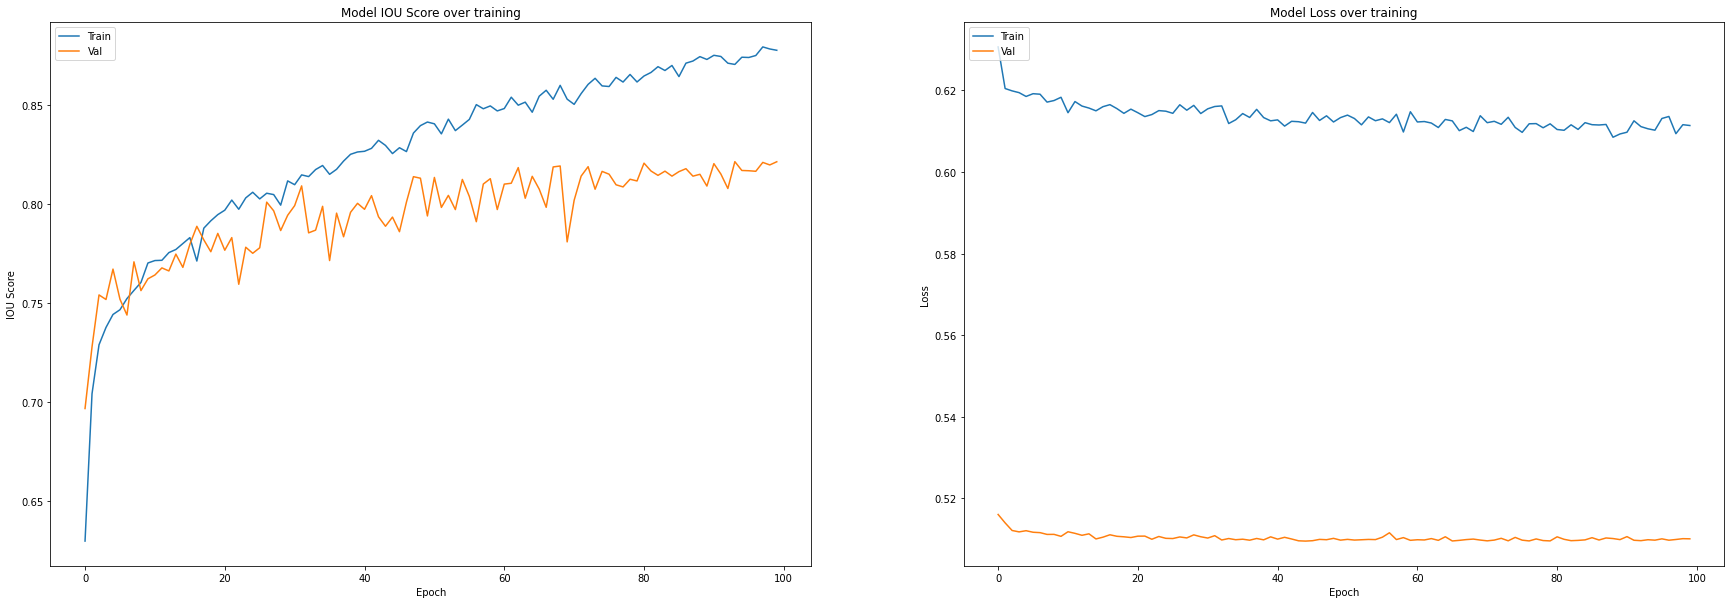

In [14]:
#//////////////////////// Plot the train/valid logs \\\\\\\\\\\\\\\\\\\\\\\\
f = open(os.path.join(output_dir, 'train_logs.txt'))
lines_tr = f.readlines()
f.close()

f = open(os.path.join(output_dir, 'train_logs.txt'))
lines_tr = f.readlines()
f.close()
lines_tr = [line for i,line in enumerate(lines_tr) if i > 0]

f = open(os.path.join(output_dir, 'valid_logs.txt'))
lines_val = f.readlines()
f.close()
lines_val = [line for i,line in enumerate(lines_val) if i > 0]

scores_tr = [json.loads(line[4:].replace("\'", "\"")) for line in lines_tr]
scores_val = [json.loads(line[4:].replace("\'", "\"")) for line in lines_val]

iou_train = [float(dic['IOU Score']) for dic in scores_tr]
iou_val = [float(dic['IOU Score']) for dic in scores_val]

loss_train = [float(dic['LOSS']) for dic in scores_tr]
loss_val = [float(dic['LOSS']) for dic in scores_val]

plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(iou_train)
plt.plot(iou_val)
plt.title("Model IOU Score over training")
plt.xlabel('Epoch')
plt.ylabel('IOU Score')
plt.legend(['Train', 'Val'], loc = 'upper left')

plt.subplot(1,2,2)
plt.plot(loss_train)
plt.plot(loss_val)
plt.title("Model Loss over training")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

C:\Users\CITY3\Desktop\PD-Seg Work\2017\images\27769.png
(1024, 1024)
(1024, 1024, 1)
(1024, 1024, 3)


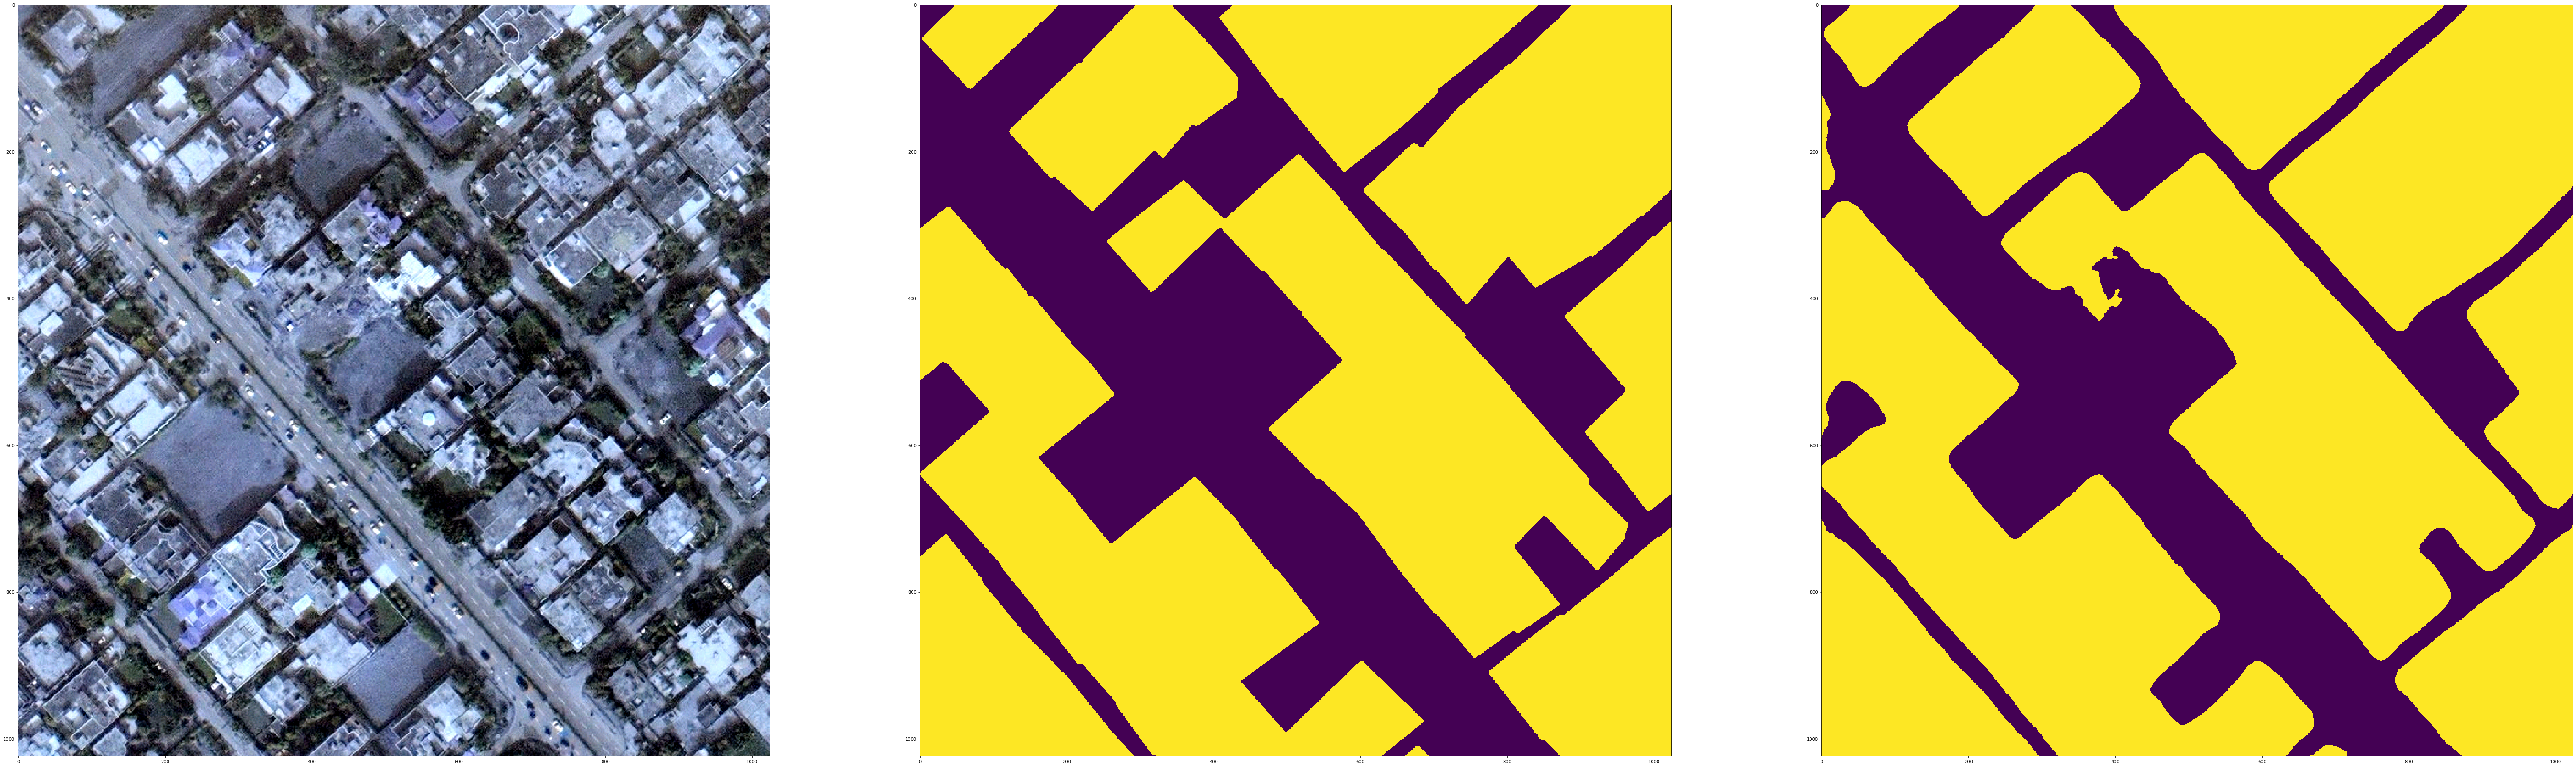

In [48]:
#//////////////////////// Visualize Results on an image from Test Set \\\\\\\\\\\\\\\\\\\\\\\\
# test_images_dir = os.path.join(data_dir, 'test\images')
test_images_dir = r"C:\Users\CITY3\Desktop\PD-Seg Work\2017\images"

# load best weights
best_model = torch.load(os.path.join(output_dir,'best_model.h5'), map_location=DEVICE)

image = os.listdir(test_images_dir)[os.listdir(test_images_dir).index("27769.png")]

# for image in os.listdir(images_dir):
image_path = os.path.join(test_images_dir, image)
img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

mask_path = image_path.replace(".png", ".npy").replace("images", "masks")
gt_mask = np.load(mask_path)
gt_mask = (gt_mask > 0).astype(np.int32)

preprocessing=get_preprocessing(preprocessing_fn)
sample = preprocessing(image=img, mask=gt_mask)
img, gt_mask = sample['image'], sample['mask']

img = np.transpose(img, (2, 0, 1)).astype('float32')

print(image_path)
#gt_mask = np.transpose(gt_mask,(1,2,0))

x_tensor = torch.from_numpy(img).to(DEVICE).unsqueeze(0)
#image = image.squeeze()
img = np.transpose(img,(1,2,0))

best_model.eval()
with torch.no_grad():
    pred_mask = best_model(x_tensor)
    
pr_mask = pred_mask.squeeze().round()
pr_mask = pr_mask.detach().squeeze().cpu().numpy()

print(pr_mask.shape)
print(gt_mask.shape)
print(img.shape)

plt.figure(figsize=(100,100))
plt.subplot(1,3,1)
plt.imshow(denormalize(img.squeeze()), interpolation='none')
plt.subplot(1,3,2)
plt.imshow(gt_mask, interpolation='none')
plt.subplot(1,3,3)
plt.imshow(pr_mask, interpolation='none')
plt.show()

In [31]:
#//////////////////////// Evaluate Score on the Test Dataset \\\\\\\\\\\\\\\\\\\\\\\\
test_images_dir = os.path.join(data_dir, 'test\images')

# load best weights
best_model = torch.load(os.path.join(output_dir,'best_model.h5'), map_location=DEVICE)
best_model.eval()

preprocessing=get_preprocessing(preprocessing_fn)
metrics_meters = {name: np.array([]) for name, func in metrics.items()}

for image in tqdm(os.listdir(test_images_dir)):
    image_path = os.path.join(test_images_dir, image)
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

    mask_path = image_path.replace(".png", ".npy").replace("images", "masks")
    mask = np.load(mask_path)
    mask = (mask > 0).astype(np.int32).squeeze()

    sample = preprocessing(image=img, mask=mask)
    img, mask = sample['image'], sample['mask']

    img = np.transpose(img, (2, 0, 1)).astype('float32')

    x_tensor = torch.from_numpy(img).to(DEVICE).unsqueeze(0)
    y_tensor = torch.from_numpy(mask).to(DEVICE).unsqueeze(0)

    with torch.no_grad():
        y_pred = best_model(x_tensor)

    if mode == mode_choices[2]:
        tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(y_pred, dim=1), y_tensor, mode=mode,
                                               threshold=threshold)
    elif mode == mode_choices[1]:
        tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(y_pred, dim=1), y_tensor, mode=mode,
                                               num_classes=n_classes)
    elif mode == mode_choices[0]:
        tp, fp, fn, tn = smp.metrics.get_stats(torch.squeeze(y_pred, dim=1), y_tensor, mode=mode,
                                               threshold=threshold)

    # update metrics logs
    for name, metric_fn in metrics.items():
        metric_value = metric_fn(tp, fp, fn, tn).cpu().detach().numpy()
        metrics_meter = metrics_meters[name]
        metrics_meters[name] = np.append(metrics_meter, metric_value)
        
    metrics_logs = {name: np.mean(vals) for name, vals in metrics_meters.items()}
        
print(metrics_logs)

100%|████████████████████████████████████████████████████████████████████████████████| 588/588 [01:09<00:00,  8.43it/s]

{'IOU Score': 0.8328938920761427, 'F1 Score': 0.8800916677351411, 'F_beta score': 0.8800916677351411, 'Accuracy': 0.9489306024953622, 'Recall': 0.9427213494629493}


In [52]:
#//////////////////////// Evaluate on Large Tiff File(s) \\\\\\\\\\\\\\\\\\\\\\\\
#input_imgs = os.path.join(data_dir, 'tiff_images') # Input the path to tiff images
input_imgs = r"C:\Users\CITY3\Desktop\test region.tif"
# model_path = os.path.join(output_dir,'best_model.h5'), map_location=DEVICE
out_dir = r"C:\Users\CITY3\Desktop\OUTPUT"

ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'

target_size = (1024, 1024)
padding_pixels = (100, 100)
padding_value = 0
downsampling_factor = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PIX_VALUE_MAX = 255    # The max data value we have
PIX_VALUE_MAX_REQ = 255 # The max data value we need

model = torch.load(os.path.join(output_dir, 'best_model.h5'), map_location=DEVICE)
model.eval()
imgs = [file for file in glob.glob(input_imgs) if file.endswith('.tif')]
print(imgs)
assert len(imgs) > 0, "The number of images equal to zero"

#num_processes = 1
print("Running on {} images".format(len(imgs)))# using {} parallel processes".format(len(imgs), num_processes))

# pos = len(input_imgs.split('*')[0]) #Related to naming of output file

#args = [[img, DEVICE, model, args.output_dir] for img in imgs]

'''
if num_processes > 1:
    p = mlt.Pool(num_processes)
    (p.map(process, args))
    p.close()
else:
    for arg in args:
        process(arg)'''

#img_path, device, model, output_dir, pos = args[0]

for img_path in imgs:
    #img_path = imgs[0]
    file_name = os.path.split(img_path)[-1].split('.')[0]
    print("Running for {}".format(file_name))

    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    save_path = os.path.join(out_dir, file_name + "_preds.npy")
    img = np.transpose(rasterio.open(img_path).read(), (1, 2, 0))
#     max_value = np.iinfo(img.dtype).max
    print("Actual Image Size: {}".format(img.shape))

    #Define k_x, k_y to define 'useful' portion, since we are taking patches with overlapping area.
    k_y = target_size[0] - 2 * padding_pixels[0]
    k_x = target_size[1] - 2 * padding_pixels[1]

    # First padding: To make divisible by k
    cols = (math.ceil(img.shape[0]/k_y))
    rows = (math.ceil(img.shape[1]/k_x))

    pad_bottom = cols*k_y - img.shape[0]   #pixels to add in y direction
    pad_right = rows*k_x - img.shape[1]    #pixels to add in x direction
    if pad_bottom > 0 or pad_right > 0:
        print("Running cv2 padding..")
        img = cv2.copyMakeBorder(img, 0, pad_bottom, 0, pad_right, cv2.BORDER_CONSTANT, value=padding_value)
    print("Image Size after making divisible by ({}, {}): {}".format(k_x, k_y, img.shape))

    output_image = np.zeros((int(img.shape[0]*downsampling_factor), int(img.shape[1]*downsampling_factor)), dtype=np.uint8) * 255
    print("Size of output image after downsampling factor of {}: {}".format(downsampling_factor, output_image.shape))

    # Second Padding: To add boundary padding pixels
    img = cv2.copyMakeBorder(img, padding_pixels[0], padding_pixels[0], padding_pixels[1], 
                             padding_pixels[1], cv2.BORDER_CONSTANT, value=padding_value)
    print("Image Size after adding ({}, {}) boundary pixels: {}".format(padding_pixels[0], padding_pixels[0], img.shape))

    # Load pre-processing function
    preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
    preprocessing = get_preprocessing(preprocessing_fn)

    total_patches = rows*cols
    print("Total {} patches for the given image {}".format(rows*cols, file_name))
    for y_idx in range(cols):
        y1 = y_idx*k_y + padding_pixels[0]
        y2 = y1 + k_y
#         if y_idx <= 0:
#             continue
        for x_idx in range(rows):
            x1 = x_idx*k_x + padding_pixels[1]
            x2 = x1 + k_x
            patch_number = y_idx*rows + x_idx + 1

            img_crop = img[y1-padding_pixels[0]: y2 + padding_pixels[0], x1 - padding_pixels[1]: x2 + padding_pixels[1]]
            print("Patch {} of {}: [{}:{}, {}:{}]".format(patch_number, total_patches, y1-padding_pixels[0],
                                                          y2 + padding_pixels[0], x1 - padding_pixels[1],
                                                          x2 + padding_pixels[1]), end =" ")
            
            img_crop = ((img_crop/PIX_VALUE_MAX)*(PIX_VALUE_MAX_REQ)).astype(np.uint8)
#             plt.subplot(1, 2, 1)
#             plt.imshow(img_crop)
#             print(img_crop.max())
            sample = preprocessing(image=img_crop)
            image = cv2.resize(sample['image'], 
                               (int(downsampling_factor * target_size[0]),
                                int(downsampling_factor * target_size[1])),
                               interpolation = cv2.INTER_AREA)
#             plt.subplot(1, 2, 2)
#             plt.imshow(denormalize(image))
#             plt.show()
#             print(image.max())
            x_tensor = torch.Tensor(image).permute(2, 0, 1).to(DEVICE).unsqueeze(0)
#             image = np.transpose(image, (2, 0, 1))#.astype('float32')
#             x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
            with torch.no_grad():
                pred_mask = model(x_tensor)
            pr_mask = pred_mask.squeeze()
            pr_mask = pr_mask.detach().squeeze().cpu().numpy().round()

            patch = pr_mask[int(downsampling_factor * padding_pixels[0]) : int(downsampling_factor * (target_size[0] - padding_pixels[0])),
                            int(downsampling_factor * padding_pixels[1]) : int(downsampling_factor * (target_size[1] - padding_pixels[1]))]
#             print(",Output: [{}:{}, {}:{}]".format(int(downsampling_factor*(y_idx*k_y)), int(downsampling_factor*(y_idx*k_y + k_y)),
#                                                    int(downsampling_factor*(x_idx*k_x)), int(downsampling_factor*(x_idx*k_x + k_x)),
#                                                    end =" "))
            output_image[int(downsampling_factor*(y_idx*k_y)): int(downsampling_factor*(y_idx*k_y + k_y)),
                           int(downsampling_factor*(x_idx*k_x)): int(downsampling_factor*(x_idx*k_x + k_x))] = patch
            print("..... Done!")
#         break


output_image = output_image[:output_image.shape[0] - int(downsampling_factor * pad_bottom),
                            :output_image.shape[1] - int(downsampling_factor * pad_right)]
print("Final shape of downsampled output image: {}".format(output_image.shape))

np.save(save_path, output_image)

['C:\\Users\\CITY3\\Desktop\\test region.tif']
Running on 1 images
Running for test region
Actual Image Size: (67652, 40724, 3)
Running cv2 padding..
Image Size after making divisible by (824, 824): (68392, 41200, 3)
Size of output image after downsampling factor of 1: (68392, 41200)
Image Size after adding (100, 100) boundary pixels: (68592, 41400, 3)
Total 4150 patches for the given image test region
Patch 1 of 4150: [0:1024, 0:1024] ..... Done!
Patch 2 of 4150: [0:1024, 824:1848] ..... Done!
Patch 3 of 4150: [0:1024, 1648:2672] ..... Done!
Patch 4 of 4150: [0:1024, 2472:3496] ..... Done!
Patch 5 of 4150: [0:1024, 3296:4320] ..... Done!
Patch 6 of 4150: [0:1024, 4120:5144] ..... Done!
Patch 7 of 4150: [0:1024, 4944:5968] ..... Done!
Patch 8 of 4150: [0:1024, 5768:6792] ..... Done!
Patch 9 of 4150: [0:1024, 6592:7616] ..... Done!
Patch 10 of 4150: [0:1024, 7416:8440] ..... Done!
Patch 11 of 4150: [0:1024, 8240:9264] ..... Done!
Patch 12 of 4150: [0:1024, 9064:10088] ..... Done!
Patch 

Patch 148 of 4150: [1648:2672, 38728:39752] ..... Done!
Patch 149 of 4150: [1648:2672, 39552:40576] ..... Done!
Patch 150 of 4150: [1648:2672, 40376:41400] ..... Done!
Patch 151 of 4150: [2472:3496, 0:1024] ..... Done!
Patch 152 of 4150: [2472:3496, 824:1848] ..... Done!
Patch 153 of 4150: [2472:3496, 1648:2672] ..... Done!
Patch 154 of 4150: [2472:3496, 2472:3496] ..... Done!
Patch 155 of 4150: [2472:3496, 3296:4320] ..... Done!
Patch 156 of 4150: [2472:3496, 4120:5144] ..... Done!
Patch 157 of 4150: [2472:3496, 4944:5968] ..... Done!
Patch 158 of 4150: [2472:3496, 5768:6792] ..... Done!
Patch 159 of 4150: [2472:3496, 6592:7616] ..... Done!
Patch 160 of 4150: [2472:3496, 7416:8440] ..... Done!
Patch 161 of 4150: [2472:3496, 8240:9264] ..... Done!
Patch 162 of 4150: [2472:3496, 9064:10088] ..... Done!
Patch 163 of 4150: [2472:3496, 9888:10912] ..... Done!
Patch 164 of 4150: [2472:3496, 10712:11736] ..... Done!
Patch 165 of 4150: [2472:3496, 11536:12560] ..... Done!
Patch 166 of 4150: [

Patch 296 of 4150: [4120:5144, 37080:38104] ..... Done!
Patch 297 of 4150: [4120:5144, 37904:38928] ..... Done!
Patch 298 of 4150: [4120:5144, 38728:39752] ..... Done!
Patch 299 of 4150: [4120:5144, 39552:40576] ..... Done!
Patch 300 of 4150: [4120:5144, 40376:41400] ..... Done!
Patch 301 of 4150: [4944:5968, 0:1024] ..... Done!
Patch 302 of 4150: [4944:5968, 824:1848] ..... Done!
Patch 303 of 4150: [4944:5968, 1648:2672] ..... Done!
Patch 304 of 4150: [4944:5968, 2472:3496] ..... Done!
Patch 305 of 4150: [4944:5968, 3296:4320] ..... Done!
Patch 306 of 4150: [4944:5968, 4120:5144] ..... Done!
Patch 307 of 4150: [4944:5968, 4944:5968] ..... Done!
Patch 308 of 4150: [4944:5968, 5768:6792] ..... Done!
Patch 309 of 4150: [4944:5968, 6592:7616] ..... Done!
Patch 310 of 4150: [4944:5968, 7416:8440] ..... Done!
Patch 311 of 4150: [4944:5968, 8240:9264] ..... Done!
Patch 312 of 4150: [4944:5968, 9064:10088] ..... Done!
Patch 313 of 4150: [4944:5968, 9888:10912] ..... Done!
Patch 314 of 4150: [

Patch 444 of 4150: [6592:7616, 35432:36456] ..... Done!
Patch 445 of 4150: [6592:7616, 36256:37280] ..... Done!
Patch 446 of 4150: [6592:7616, 37080:38104] ..... Done!
Patch 447 of 4150: [6592:7616, 37904:38928] ..... Done!
Patch 448 of 4150: [6592:7616, 38728:39752] ..... Done!
Patch 449 of 4150: [6592:7616, 39552:40576] ..... Done!
Patch 450 of 4150: [6592:7616, 40376:41400] ..... Done!
Patch 451 of 4150: [7416:8440, 0:1024] ..... Done!
Patch 452 of 4150: [7416:8440, 824:1848] ..... Done!
Patch 453 of 4150: [7416:8440, 1648:2672] ..... Done!
Patch 454 of 4150: [7416:8440, 2472:3496] ..... Done!
Patch 455 of 4150: [7416:8440, 3296:4320] ..... Done!
Patch 456 of 4150: [7416:8440, 4120:5144] ..... Done!
Patch 457 of 4150: [7416:8440, 4944:5968] ..... Done!
Patch 458 of 4150: [7416:8440, 5768:6792] ..... Done!
Patch 459 of 4150: [7416:8440, 6592:7616] ..... Done!
Patch 460 of 4150: [7416:8440, 7416:8440] ..... Done!
Patch 461 of 4150: [7416:8440, 8240:9264] ..... Done!
Patch 462 of 4150:

Patch 592 of 4150: [9064:10088, 33784:34808] ..... Done!
Patch 593 of 4150: [9064:10088, 34608:35632] ..... Done!
Patch 594 of 4150: [9064:10088, 35432:36456] ..... Done!
Patch 595 of 4150: [9064:10088, 36256:37280] ..... Done!
Patch 596 of 4150: [9064:10088, 37080:38104] ..... Done!
Patch 597 of 4150: [9064:10088, 37904:38928] ..... Done!
Patch 598 of 4150: [9064:10088, 38728:39752] ..... Done!
Patch 599 of 4150: [9064:10088, 39552:40576] ..... Done!
Patch 600 of 4150: [9064:10088, 40376:41400] ..... Done!
Patch 601 of 4150: [9888:10912, 0:1024] ..... Done!
Patch 602 of 4150: [9888:10912, 824:1848] ..... Done!
Patch 603 of 4150: [9888:10912, 1648:2672] ..... Done!
Patch 604 of 4150: [9888:10912, 2472:3496] ..... Done!
Patch 605 of 4150: [9888:10912, 3296:4320] ..... Done!
Patch 606 of 4150: [9888:10912, 4120:5144] ..... Done!
Patch 607 of 4150: [9888:10912, 4944:5968] ..... Done!
Patch 608 of 4150: [9888:10912, 5768:6792] ..... Done!
Patch 609 of 4150: [9888:10912, 6592:7616] ..... Do

Patch 735 of 4150: [11536:12560, 28016:29040] ..... Done!
Patch 736 of 4150: [11536:12560, 28840:29864] ..... Done!
Patch 737 of 4150: [11536:12560, 29664:30688] ..... Done!
Patch 738 of 4150: [11536:12560, 30488:31512] ..... Done!
Patch 739 of 4150: [11536:12560, 31312:32336] ..... Done!
Patch 740 of 4150: [11536:12560, 32136:33160] ..... Done!
Patch 741 of 4150: [11536:12560, 32960:33984] ..... Done!
Patch 742 of 4150: [11536:12560, 33784:34808] ..... Done!
Patch 743 of 4150: [11536:12560, 34608:35632] ..... Done!
Patch 744 of 4150: [11536:12560, 35432:36456] ..... Done!
Patch 745 of 4150: [11536:12560, 36256:37280] ..... Done!
Patch 746 of 4150: [11536:12560, 37080:38104] ..... Done!
Patch 747 of 4150: [11536:12560, 37904:38928] ..... Done!
Patch 748 of 4150: [11536:12560, 38728:39752] ..... Done!
Patch 749 of 4150: [11536:12560, 39552:40576] ..... Done!
Patch 750 of 4150: [11536:12560, 40376:41400] ..... Done!
Patch 751 of 4150: [12360:13384, 0:1024] ..... Done!
Patch 752 of 4150: 

Patch 878 of 4150: [14008:15032, 22248:23272] ..... Done!
Patch 879 of 4150: [14008:15032, 23072:24096] ..... Done!
Patch 880 of 4150: [14008:15032, 23896:24920] ..... Done!
Patch 881 of 4150: [14008:15032, 24720:25744] ..... Done!
Patch 882 of 4150: [14008:15032, 25544:26568] ..... Done!
Patch 883 of 4150: [14008:15032, 26368:27392] ..... Done!
Patch 884 of 4150: [14008:15032, 27192:28216] ..... Done!
Patch 885 of 4150: [14008:15032, 28016:29040] ..... Done!
Patch 886 of 4150: [14008:15032, 28840:29864] ..... Done!
Patch 887 of 4150: [14008:15032, 29664:30688] ..... Done!
Patch 888 of 4150: [14008:15032, 30488:31512] ..... Done!
Patch 889 of 4150: [14008:15032, 31312:32336] ..... Done!
Patch 890 of 4150: [14008:15032, 32136:33160] ..... Done!
Patch 891 of 4150: [14008:15032, 32960:33984] ..... Done!
Patch 892 of 4150: [14008:15032, 33784:34808] ..... Done!
Patch 893 of 4150: [14008:15032, 34608:35632] ..... Done!
Patch 894 of 4150: [14008:15032, 35432:36456] ..... Done!
Patch 895 of 4

Patch 1020 of 4150: [16480:17504, 15656:16680] ..... Done!
Patch 1021 of 4150: [16480:17504, 16480:17504] ..... Done!
Patch 1022 of 4150: [16480:17504, 17304:18328] ..... Done!
Patch 1023 of 4150: [16480:17504, 18128:19152] ..... Done!
Patch 1024 of 4150: [16480:17504, 18952:19976] ..... Done!
Patch 1025 of 4150: [16480:17504, 19776:20800] ..... Done!
Patch 1026 of 4150: [16480:17504, 20600:21624] ..... Done!
Patch 1027 of 4150: [16480:17504, 21424:22448] ..... Done!
Patch 1028 of 4150: [16480:17504, 22248:23272] ..... Done!
Patch 1029 of 4150: [16480:17504, 23072:24096] ..... Done!
Patch 1030 of 4150: [16480:17504, 23896:24920] ..... Done!
Patch 1031 of 4150: [16480:17504, 24720:25744] ..... Done!
Patch 1032 of 4150: [16480:17504, 25544:26568] ..... Done!
Patch 1033 of 4150: [16480:17504, 26368:27392] ..... Done!
Patch 1034 of 4150: [16480:17504, 27192:28216] ..... Done!
Patch 1035 of 4150: [16480:17504, 28016:29040] ..... Done!
Patch 1036 of 4150: [16480:17504, 28840:29864] ..... Don

Patch 1161 of 4150: [18952:19976, 8240:9264] ..... Done!
Patch 1162 of 4150: [18952:19976, 9064:10088] ..... Done!
Patch 1163 of 4150: [18952:19976, 9888:10912] ..... Done!
Patch 1164 of 4150: [18952:19976, 10712:11736] ..... Done!
Patch 1165 of 4150: [18952:19976, 11536:12560] ..... Done!
Patch 1166 of 4150: [18952:19976, 12360:13384] ..... Done!
Patch 1167 of 4150: [18952:19976, 13184:14208] ..... Done!
Patch 1168 of 4150: [18952:19976, 14008:15032] ..... Done!
Patch 1169 of 4150: [18952:19976, 14832:15856] ..... Done!
Patch 1170 of 4150: [18952:19976, 15656:16680] ..... Done!
Patch 1171 of 4150: [18952:19976, 16480:17504] ..... Done!
Patch 1172 of 4150: [18952:19976, 17304:18328] ..... Done!
Patch 1173 of 4150: [18952:19976, 18128:19152] ..... Done!
Patch 1174 of 4150: [18952:19976, 18952:19976] ..... Done!
Patch 1175 of 4150: [18952:19976, 19776:20800] ..... Done!
Patch 1176 of 4150: [18952:19976, 20600:21624] ..... Done!
Patch 1177 of 4150: [18952:19976, 21424:22448] ..... Done!
P

Patch 1301 of 4150: [21424:22448, 0:1024] ..... Done!
Patch 1302 of 4150: [21424:22448, 824:1848] ..... Done!
Patch 1303 of 4150: [21424:22448, 1648:2672] ..... Done!
Patch 1304 of 4150: [21424:22448, 2472:3496] ..... Done!
Patch 1305 of 4150: [21424:22448, 3296:4320] ..... Done!
Patch 1306 of 4150: [21424:22448, 4120:5144] ..... Done!
Patch 1307 of 4150: [21424:22448, 4944:5968] ..... Done!
Patch 1308 of 4150: [21424:22448, 5768:6792] ..... Done!
Patch 1309 of 4150: [21424:22448, 6592:7616] ..... Done!
Patch 1310 of 4150: [21424:22448, 7416:8440] ..... Done!
Patch 1311 of 4150: [21424:22448, 8240:9264] ..... Done!
Patch 1312 of 4150: [21424:22448, 9064:10088] ..... Done!
Patch 1313 of 4150: [21424:22448, 9888:10912] ..... Done!
Patch 1314 of 4150: [21424:22448, 10712:11736] ..... Done!
Patch 1315 of 4150: [21424:22448, 11536:12560] ..... Done!
Patch 1316 of 4150: [21424:22448, 12360:13384] ..... Done!
Patch 1317 of 4150: [21424:22448, 13184:14208] ..... Done!
Patch 1318 of 4150: [2142

Patch 1441 of 4150: [23072:24096, 32960:33984] ..... Done!
Patch 1442 of 4150: [23072:24096, 33784:34808] ..... Done!
Patch 1443 of 4150: [23072:24096, 34608:35632] ..... Done!
Patch 1444 of 4150: [23072:24096, 35432:36456] ..... Done!
Patch 1445 of 4150: [23072:24096, 36256:37280] ..... Done!
Patch 1446 of 4150: [23072:24096, 37080:38104] ..... Done!
Patch 1447 of 4150: [23072:24096, 37904:38928] ..... Done!
Patch 1448 of 4150: [23072:24096, 38728:39752] ..... Done!
Patch 1449 of 4150: [23072:24096, 39552:40576] ..... Done!
Patch 1450 of 4150: [23072:24096, 40376:41400] ..... Done!
Patch 1451 of 4150: [23896:24920, 0:1024] ..... Done!
Patch 1452 of 4150: [23896:24920, 824:1848] ..... Done!
Patch 1453 of 4150: [23896:24920, 1648:2672] ..... Done!
Patch 1454 of 4150: [23896:24920, 2472:3496] ..... Done!
Patch 1455 of 4150: [23896:24920, 3296:4320] ..... Done!
Patch 1456 of 4150: [23896:24920, 4120:5144] ..... Done!
Patch 1457 of 4150: [23896:24920, 4944:5968] ..... Done!
Patch 1458 of 4

Patch 1582 of 4150: [25544:26568, 25544:26568] ..... Done!
Patch 1583 of 4150: [25544:26568, 26368:27392] ..... Done!
Patch 1584 of 4150: [25544:26568, 27192:28216] ..... Done!
Patch 1585 of 4150: [25544:26568, 28016:29040] ..... Done!
Patch 1586 of 4150: [25544:26568, 28840:29864] ..... Done!
Patch 1587 of 4150: [25544:26568, 29664:30688] ..... Done!
Patch 1588 of 4150: [25544:26568, 30488:31512] ..... Done!
Patch 1589 of 4150: [25544:26568, 31312:32336] ..... Done!
Patch 1590 of 4150: [25544:26568, 32136:33160] ..... Done!
Patch 1591 of 4150: [25544:26568, 32960:33984] ..... Done!
Patch 1592 of 4150: [25544:26568, 33784:34808] ..... Done!
Patch 1593 of 4150: [25544:26568, 34608:35632] ..... Done!
Patch 1594 of 4150: [25544:26568, 35432:36456] ..... Done!
Patch 1595 of 4150: [25544:26568, 36256:37280] ..... Done!
Patch 1596 of 4150: [25544:26568, 37080:38104] ..... Done!
Patch 1597 of 4150: [25544:26568, 37904:38928] ..... Done!
Patch 1598 of 4150: [25544:26568, 38728:39752] ..... Don

Patch 1723 of 4150: [28016:29040, 18128:19152] ..... Done!
Patch 1724 of 4150: [28016:29040, 18952:19976] ..... Done!
Patch 1725 of 4150: [28016:29040, 19776:20800] ..... Done!
Patch 1726 of 4150: [28016:29040, 20600:21624] ..... Done!
Patch 1727 of 4150: [28016:29040, 21424:22448] ..... Done!
Patch 1728 of 4150: [28016:29040, 22248:23272] ..... Done!
Patch 1729 of 4150: [28016:29040, 23072:24096] ..... Done!
Patch 1730 of 4150: [28016:29040, 23896:24920] ..... Done!
Patch 1731 of 4150: [28016:29040, 24720:25744] ..... Done!
Patch 1732 of 4150: [28016:29040, 25544:26568] ..... Done!
Patch 1733 of 4150: [28016:29040, 26368:27392] ..... Done!
Patch 1734 of 4150: [28016:29040, 27192:28216] ..... Done!
Patch 1735 of 4150: [28016:29040, 28016:29040] ..... Done!
Patch 1736 of 4150: [28016:29040, 28840:29864] ..... Done!
Patch 1737 of 4150: [28016:29040, 29664:30688] ..... Done!
Patch 1738 of 4150: [28016:29040, 30488:31512] ..... Done!
Patch 1739 of 4150: [28016:29040, 31312:32336] ..... Don

Patch 1864 of 4150: [30488:31512, 10712:11736] ..... Done!
Patch 1865 of 4150: [30488:31512, 11536:12560] ..... Done!
Patch 1866 of 4150: [30488:31512, 12360:13384] ..... Done!
Patch 1867 of 4150: [30488:31512, 13184:14208] ..... Done!
Patch 1868 of 4150: [30488:31512, 14008:15032] ..... Done!
Patch 1869 of 4150: [30488:31512, 14832:15856] ..... Done!
Patch 1870 of 4150: [30488:31512, 15656:16680] ..... Done!
Patch 1871 of 4150: [30488:31512, 16480:17504] ..... Done!
Patch 1872 of 4150: [30488:31512, 17304:18328] ..... Done!
Patch 1873 of 4150: [30488:31512, 18128:19152] ..... Done!
Patch 1874 of 4150: [30488:31512, 18952:19976] ..... Done!
Patch 1875 of 4150: [30488:31512, 19776:20800] ..... Done!
Patch 1876 of 4150: [30488:31512, 20600:21624] ..... Done!
Patch 1877 of 4150: [30488:31512, 21424:22448] ..... Done!
Patch 1878 of 4150: [30488:31512, 22248:23272] ..... Done!
Patch 1879 of 4150: [30488:31512, 23072:24096] ..... Done!
Patch 1880 of 4150: [30488:31512, 23896:24920] ..... Don

Patch 2005 of 4150: [32960:33984, 3296:4320] ..... Done!
Patch 2006 of 4150: [32960:33984, 4120:5144] ..... Done!
Patch 2007 of 4150: [32960:33984, 4944:5968] ..... Done!
Patch 2008 of 4150: [32960:33984, 5768:6792] ..... Done!
Patch 2009 of 4150: [32960:33984, 6592:7616] ..... Done!
Patch 2010 of 4150: [32960:33984, 7416:8440] ..... Done!
Patch 2011 of 4150: [32960:33984, 8240:9264] ..... Done!
Patch 2012 of 4150: [32960:33984, 9064:10088] ..... Done!
Patch 2013 of 4150: [32960:33984, 9888:10912] ..... Done!
Patch 2014 of 4150: [32960:33984, 10712:11736] ..... Done!
Patch 2015 of 4150: [32960:33984, 11536:12560] ..... Done!
Patch 2016 of 4150: [32960:33984, 12360:13384] ..... Done!
Patch 2017 of 4150: [32960:33984, 13184:14208] ..... Done!
Patch 2018 of 4150: [32960:33984, 14008:15032] ..... Done!
Patch 2019 of 4150: [32960:33984, 14832:15856] ..... Done!
Patch 2020 of 4150: [32960:33984, 15656:16680] ..... Done!
Patch 2021 of 4150: [32960:33984, 16480:17504] ..... Done!
Patch 2022 of

Patch 2145 of 4150: [34608:35632, 36256:37280] ..... Done!
Patch 2146 of 4150: [34608:35632, 37080:38104] ..... Done!
Patch 2147 of 4150: [34608:35632, 37904:38928] ..... Done!
Patch 2148 of 4150: [34608:35632, 38728:39752] ..... Done!
Patch 2149 of 4150: [34608:35632, 39552:40576] ..... Done!
Patch 2150 of 4150: [34608:35632, 40376:41400] ..... Done!
Patch 2151 of 4150: [35432:36456, 0:1024] ..... Done!
Patch 2152 of 4150: [35432:36456, 824:1848] ..... Done!
Patch 2153 of 4150: [35432:36456, 1648:2672] ..... Done!
Patch 2154 of 4150: [35432:36456, 2472:3496] ..... Done!
Patch 2155 of 4150: [35432:36456, 3296:4320] ..... Done!
Patch 2156 of 4150: [35432:36456, 4120:5144] ..... Done!
Patch 2157 of 4150: [35432:36456, 4944:5968] ..... Done!
Patch 2158 of 4150: [35432:36456, 5768:6792] ..... Done!
Patch 2159 of 4150: [35432:36456, 6592:7616] ..... Done!
Patch 2160 of 4150: [35432:36456, 7416:8440] ..... Done!
Patch 2161 of 4150: [35432:36456, 8240:9264] ..... Done!
Patch 2162 of 4150: [35

Patch 2285 of 4150: [37080:38104, 28016:29040] ..... Done!
Patch 2286 of 4150: [37080:38104, 28840:29864] ..... Done!
Patch 2287 of 4150: [37080:38104, 29664:30688] ..... Done!
Patch 2288 of 4150: [37080:38104, 30488:31512] ..... Done!
Patch 2289 of 4150: [37080:38104, 31312:32336] ..... Done!
Patch 2290 of 4150: [37080:38104, 32136:33160] ..... Done!
Patch 2291 of 4150: [37080:38104, 32960:33984] ..... Done!
Patch 2292 of 4150: [37080:38104, 33784:34808] ..... Done!
Patch 2293 of 4150: [37080:38104, 34608:35632] ..... Done!
Patch 2294 of 4150: [37080:38104, 35432:36456] ..... Done!
Patch 2295 of 4150: [37080:38104, 36256:37280] ..... Done!
Patch 2296 of 4150: [37080:38104, 37080:38104] ..... Done!
Patch 2297 of 4150: [37080:38104, 37904:38928] ..... Done!
Patch 2298 of 4150: [37080:38104, 38728:39752] ..... Done!
Patch 2299 of 4150: [37080:38104, 39552:40576] ..... Done!
Patch 2300 of 4150: [37080:38104, 40376:41400] ..... Done!
Patch 2301 of 4150: [37904:38928, 0:1024] ..... Done!
Pa

Patch 2425 of 4150: [39552:40576, 19776:20800] ..... Done!
Patch 2426 of 4150: [39552:40576, 20600:21624] ..... Done!
Patch 2427 of 4150: [39552:40576, 21424:22448] ..... Done!
Patch 2428 of 4150: [39552:40576, 22248:23272] ..... Done!
Patch 2429 of 4150: [39552:40576, 23072:24096] ..... Done!
Patch 2430 of 4150: [39552:40576, 23896:24920] ..... Done!
Patch 2431 of 4150: [39552:40576, 24720:25744] ..... Done!
Patch 2432 of 4150: [39552:40576, 25544:26568] ..... Done!
Patch 2433 of 4150: [39552:40576, 26368:27392] ..... Done!
Patch 2434 of 4150: [39552:40576, 27192:28216] ..... Done!
Patch 2435 of 4150: [39552:40576, 28016:29040] ..... Done!
Patch 2436 of 4150: [39552:40576, 28840:29864] ..... Done!
Patch 2437 of 4150: [39552:40576, 29664:30688] ..... Done!
Patch 2438 of 4150: [39552:40576, 30488:31512] ..... Done!
Patch 2439 of 4150: [39552:40576, 31312:32336] ..... Done!
Patch 2440 of 4150: [39552:40576, 32136:33160] ..... Done!
Patch 2441 of 4150: [39552:40576, 32960:33984] ..... Don

Patch 2565 of 4150: [42024:43048, 11536:12560] ..... Done!
Patch 2566 of 4150: [42024:43048, 12360:13384] ..... Done!
Patch 2567 of 4150: [42024:43048, 13184:14208] ..... Done!
Patch 2568 of 4150: [42024:43048, 14008:15032] ..... Done!
Patch 2569 of 4150: [42024:43048, 14832:15856] ..... Done!
Patch 2570 of 4150: [42024:43048, 15656:16680] ..... Done!
Patch 2571 of 4150: [42024:43048, 16480:17504] ..... Done!
Patch 2572 of 4150: [42024:43048, 17304:18328] ..... Done!
Patch 2573 of 4150: [42024:43048, 18128:19152] ..... Done!
Patch 2574 of 4150: [42024:43048, 18952:19976] ..... Done!
Patch 2575 of 4150: [42024:43048, 19776:20800] ..... Done!
Patch 2576 of 4150: [42024:43048, 20600:21624] ..... Done!
Patch 2577 of 4150: [42024:43048, 21424:22448] ..... Done!
Patch 2578 of 4150: [42024:43048, 22248:23272] ..... Done!
Patch 2579 of 4150: [42024:43048, 23072:24096] ..... Done!
Patch 2580 of 4150: [42024:43048, 23896:24920] ..... Done!
Patch 2581 of 4150: [42024:43048, 24720:25744] ..... Don

Patch 2706 of 4150: [44496:45520, 4120:5144] ..... Done!
Patch 2707 of 4150: [44496:45520, 4944:5968] ..... Done!
Patch 2708 of 4150: [44496:45520, 5768:6792] ..... Done!
Patch 2709 of 4150: [44496:45520, 6592:7616] ..... Done!
Patch 2710 of 4150: [44496:45520, 7416:8440] ..... Done!
Patch 2711 of 4150: [44496:45520, 8240:9264] ..... Done!
Patch 2712 of 4150: [44496:45520, 9064:10088] ..... Done!
Patch 2713 of 4150: [44496:45520, 9888:10912] ..... Done!
Patch 2714 of 4150: [44496:45520, 10712:11736] ..... Done!
Patch 2715 of 4150: [44496:45520, 11536:12560] ..... Done!
Patch 2716 of 4150: [44496:45520, 12360:13384] ..... Done!
Patch 2717 of 4150: [44496:45520, 13184:14208] ..... Done!
Patch 2718 of 4150: [44496:45520, 14008:15032] ..... Done!
Patch 2719 of 4150: [44496:45520, 14832:15856] ..... Done!
Patch 2720 of 4150: [44496:45520, 15656:16680] ..... Done!
Patch 2721 of 4150: [44496:45520, 16480:17504] ..... Done!
Patch 2722 of 4150: [44496:45520, 17304:18328] ..... Done!
Patch 2723 

Patch 2847 of 4150: [46144:47168, 37904:38928] ..... Done!
Patch 2848 of 4150: [46144:47168, 38728:39752] ..... Done!
Patch 2849 of 4150: [46144:47168, 39552:40576] ..... Done!
Patch 2850 of 4150: [46144:47168, 40376:41400] ..... Done!
Patch 2851 of 4150: [46968:47992, 0:1024] ..... Done!
Patch 2852 of 4150: [46968:47992, 824:1848] ..... Done!
Patch 2853 of 4150: [46968:47992, 1648:2672] ..... Done!
Patch 2854 of 4150: [46968:47992, 2472:3496] ..... Done!
Patch 2855 of 4150: [46968:47992, 3296:4320] ..... Done!
Patch 2856 of 4150: [46968:47992, 4120:5144] ..... Done!
Patch 2857 of 4150: [46968:47992, 4944:5968] ..... Done!
Patch 2858 of 4150: [46968:47992, 5768:6792] ..... Done!
Patch 2859 of 4150: [46968:47992, 6592:7616] ..... Done!
Patch 2860 of 4150: [46968:47992, 7416:8440] ..... Done!
Patch 2861 of 4150: [46968:47992, 8240:9264] ..... Done!
Patch 2862 of 4150: [46968:47992, 9064:10088] ..... Done!
Patch 2863 of 4150: [46968:47992, 9888:10912] ..... Done!
Patch 2864 of 4150: [4696

Patch 2988 of 4150: [48616:49640, 30488:31512] ..... Done!
Patch 2989 of 4150: [48616:49640, 31312:32336] ..... Done!
Patch 2990 of 4150: [48616:49640, 32136:33160] ..... Done!
Patch 2991 of 4150: [48616:49640, 32960:33984] ..... Done!
Patch 2992 of 4150: [48616:49640, 33784:34808] ..... Done!
Patch 2993 of 4150: [48616:49640, 34608:35632] ..... Done!
Patch 2994 of 4150: [48616:49640, 35432:36456] ..... Done!
Patch 2995 of 4150: [48616:49640, 36256:37280] ..... Done!
Patch 2996 of 4150: [48616:49640, 37080:38104] ..... Done!
Patch 2997 of 4150: [48616:49640, 37904:38928] ..... Done!
Patch 2998 of 4150: [48616:49640, 38728:39752] ..... Done!
Patch 2999 of 4150: [48616:49640, 39552:40576] ..... Done!
Patch 3000 of 4150: [48616:49640, 40376:41400] ..... Done!
Patch 3001 of 4150: [49440:50464, 0:1024] ..... Done!
Patch 3002 of 4150: [49440:50464, 824:1848] ..... Done!
Patch 3003 of 4150: [49440:50464, 1648:2672] ..... Done!
Patch 3004 of 4150: [49440:50464, 2472:3496] ..... Done!
Patch 300

Patch 3128 of 4150: [51088:52112, 22248:23272] ..... Done!
Patch 3129 of 4150: [51088:52112, 23072:24096] ..... Done!
Patch 3130 of 4150: [51088:52112, 23896:24920] ..... Done!
Patch 3131 of 4150: [51088:52112, 24720:25744] ..... Done!
Patch 3132 of 4150: [51088:52112, 25544:26568] ..... Done!
Patch 3133 of 4150: [51088:52112, 26368:27392] ..... Done!
Patch 3134 of 4150: [51088:52112, 27192:28216] ..... Done!
Patch 3135 of 4150: [51088:52112, 28016:29040] ..... Done!
Patch 3136 of 4150: [51088:52112, 28840:29864] ..... Done!
Patch 3137 of 4150: [51088:52112, 29664:30688] ..... Done!
Patch 3138 of 4150: [51088:52112, 30488:31512] ..... Done!
Patch 3139 of 4150: [51088:52112, 31312:32336] ..... Done!
Patch 3140 of 4150: [51088:52112, 32136:33160] ..... Done!
Patch 3141 of 4150: [51088:52112, 32960:33984] ..... Done!
Patch 3142 of 4150: [51088:52112, 33784:34808] ..... Done!
Patch 3143 of 4150: [51088:52112, 34608:35632] ..... Done!
Patch 3144 of 4150: [51088:52112, 35432:36456] ..... Don

Patch 3268 of 4150: [53560:54584, 14008:15032] ..... Done!
Patch 3269 of 4150: [53560:54584, 14832:15856] ..... Done!
Patch 3270 of 4150: [53560:54584, 15656:16680] ..... Done!
Patch 3271 of 4150: [53560:54584, 16480:17504] ..... Done!
Patch 3272 of 4150: [53560:54584, 17304:18328] ..... Done!
Patch 3273 of 4150: [53560:54584, 18128:19152] ..... Done!
Patch 3274 of 4150: [53560:54584, 18952:19976] ..... Done!
Patch 3275 of 4150: [53560:54584, 19776:20800] ..... Done!
Patch 3276 of 4150: [53560:54584, 20600:21624] ..... Done!
Patch 3277 of 4150: [53560:54584, 21424:22448] ..... Done!
Patch 3278 of 4150: [53560:54584, 22248:23272] ..... Done!
Patch 3279 of 4150: [53560:54584, 23072:24096] ..... Done!
Patch 3280 of 4150: [53560:54584, 23896:24920] ..... Done!
Patch 3281 of 4150: [53560:54584, 24720:25744] ..... Done!
Patch 3282 of 4150: [53560:54584, 25544:26568] ..... Done!
Patch 3283 of 4150: [53560:54584, 26368:27392] ..... Done!
Patch 3284 of 4150: [53560:54584, 27192:28216] ..... Don

Patch 3408 of 4150: [56032:57056, 5768:6792] ..... Done!
Patch 3409 of 4150: [56032:57056, 6592:7616] ..... Done!
Patch 3410 of 4150: [56032:57056, 7416:8440] ..... Done!
Patch 3411 of 4150: [56032:57056, 8240:9264] ..... Done!
Patch 3412 of 4150: [56032:57056, 9064:10088] ..... Done!
Patch 3413 of 4150: [56032:57056, 9888:10912] ..... Done!
Patch 3414 of 4150: [56032:57056, 10712:11736] ..... Done!
Patch 3415 of 4150: [56032:57056, 11536:12560] ..... Done!
Patch 3416 of 4150: [56032:57056, 12360:13384] ..... Done!
Patch 3417 of 4150: [56032:57056, 13184:14208] ..... Done!
Patch 3418 of 4150: [56032:57056, 14008:15032] ..... Done!
Patch 3419 of 4150: [56032:57056, 14832:15856] ..... Done!
Patch 3420 of 4150: [56032:57056, 15656:16680] ..... Done!
Patch 3421 of 4150: [56032:57056, 16480:17504] ..... Done!
Patch 3422 of 4150: [56032:57056, 17304:18328] ..... Done!
Patch 3423 of 4150: [56032:57056, 18128:19152] ..... Done!
Patch 3424 of 4150: [56032:57056, 18952:19976] ..... Done!
Patch 3

Patch 3549 of 4150: [57680:58704, 39552:40576] ..... Done!
Patch 3550 of 4150: [57680:58704, 40376:41400] ..... Done!
Patch 3551 of 4150: [58504:59528, 0:1024] ..... Done!
Patch 3552 of 4150: [58504:59528, 824:1848] ..... Done!
Patch 3553 of 4150: [58504:59528, 1648:2672] ..... Done!
Patch 3554 of 4150: [58504:59528, 2472:3496] ..... Done!
Patch 3555 of 4150: [58504:59528, 3296:4320] ..... Done!
Patch 3556 of 4150: [58504:59528, 4120:5144] ..... Done!
Patch 3557 of 4150: [58504:59528, 4944:5968] ..... Done!
Patch 3558 of 4150: [58504:59528, 5768:6792] ..... Done!
Patch 3559 of 4150: [58504:59528, 6592:7616] ..... Done!
Patch 3560 of 4150: [58504:59528, 7416:8440] ..... Done!
Patch 3561 of 4150: [58504:59528, 8240:9264] ..... Done!
Patch 3562 of 4150: [58504:59528, 9064:10088] ..... Done!
Patch 3563 of 4150: [58504:59528, 9888:10912] ..... Done!
Patch 3564 of 4150: [58504:59528, 10712:11736] ..... Done!
Patch 3565 of 4150: [58504:59528, 11536:12560] ..... Done!
Patch 3566 of 4150: [5850

Patch 3689 of 4150: [60152:61176, 31312:32336] ..... Done!
Patch 3690 of 4150: [60152:61176, 32136:33160] ..... Done!
Patch 3691 of 4150: [60152:61176, 32960:33984] ..... Done!
Patch 3692 of 4150: [60152:61176, 33784:34808] ..... Done!
Patch 3693 of 4150: [60152:61176, 34608:35632] ..... Done!
Patch 3694 of 4150: [60152:61176, 35432:36456] ..... Done!
Patch 3695 of 4150: [60152:61176, 36256:37280] ..... Done!
Patch 3696 of 4150: [60152:61176, 37080:38104] ..... Done!
Patch 3697 of 4150: [60152:61176, 37904:38928] ..... Done!
Patch 3698 of 4150: [60152:61176, 38728:39752] ..... Done!
Patch 3699 of 4150: [60152:61176, 39552:40576] ..... Done!
Patch 3700 of 4150: [60152:61176, 40376:41400] ..... Done!
Patch 3701 of 4150: [60976:62000, 0:1024] ..... Done!
Patch 3702 of 4150: [60976:62000, 824:1848] ..... Done!
Patch 3703 of 4150: [60976:62000, 1648:2672] ..... Done!
Patch 3704 of 4150: [60976:62000, 2472:3496] ..... Done!
Patch 3705 of 4150: [60976:62000, 3296:4320] ..... Done!
Patch 3706 

Patch 3829 of 4150: [62624:63648, 23072:24096] ..... Done!
Patch 3830 of 4150: [62624:63648, 23896:24920] ..... Done!
Patch 3831 of 4150: [62624:63648, 24720:25744] ..... Done!
Patch 3832 of 4150: [62624:63648, 25544:26568] ..... Done!
Patch 3833 of 4150: [62624:63648, 26368:27392] ..... Done!
Patch 3834 of 4150: [62624:63648, 27192:28216] ..... Done!
Patch 3835 of 4150: [62624:63648, 28016:29040] ..... Done!
Patch 3836 of 4150: [62624:63648, 28840:29864] ..... Done!
Patch 3837 of 4150: [62624:63648, 29664:30688] ..... Done!
Patch 3838 of 4150: [62624:63648, 30488:31512] ..... Done!
Patch 3839 of 4150: [62624:63648, 31312:32336] ..... Done!
Patch 3840 of 4150: [62624:63648, 32136:33160] ..... Done!
Patch 3841 of 4150: [62624:63648, 32960:33984] ..... Done!
Patch 3842 of 4150: [62624:63648, 33784:34808] ..... Done!
Patch 3843 of 4150: [62624:63648, 34608:35632] ..... Done!
Patch 3844 of 4150: [62624:63648, 35432:36456] ..... Done!
Patch 3845 of 4150: [62624:63648, 36256:37280] ..... Don

Patch 3970 of 4150: [65096:66120, 15656:16680] ..... Done!
Patch 3971 of 4150: [65096:66120, 16480:17504] ..... Done!
Patch 3972 of 4150: [65096:66120, 17304:18328] ..... Done!
Patch 3973 of 4150: [65096:66120, 18128:19152] ..... Done!
Patch 3974 of 4150: [65096:66120, 18952:19976] ..... Done!
Patch 3975 of 4150: [65096:66120, 19776:20800] ..... Done!
Patch 3976 of 4150: [65096:66120, 20600:21624] ..... Done!
Patch 3977 of 4150: [65096:66120, 21424:22448] ..... Done!
Patch 3978 of 4150: [65096:66120, 22248:23272] ..... Done!
Patch 3979 of 4150: [65096:66120, 23072:24096] ..... Done!
Patch 3980 of 4150: [65096:66120, 23896:24920] ..... Done!
Patch 3981 of 4150: [65096:66120, 24720:25744] ..... Done!
Patch 3982 of 4150: [65096:66120, 25544:26568] ..... Done!
Patch 3983 of 4150: [65096:66120, 26368:27392] ..... Done!
Patch 3984 of 4150: [65096:66120, 27192:28216] ..... Done!
Patch 3985 of 4150: [65096:66120, 28016:29040] ..... Done!
Patch 3986 of 4150: [65096:66120, 28840:29864] ..... Don

Patch 4110 of 4150: [67568:68592, 7416:8440] ..... Done!
Patch 4111 of 4150: [67568:68592, 8240:9264] ..... Done!
Patch 4112 of 4150: [67568:68592, 9064:10088] ..... Done!
Patch 4113 of 4150: [67568:68592, 9888:10912] ..... Done!
Patch 4114 of 4150: [67568:68592, 10712:11736] ..... Done!
Patch 4115 of 4150: [67568:68592, 11536:12560] ..... Done!
Patch 4116 of 4150: [67568:68592, 12360:13384] ..... Done!
Patch 4117 of 4150: [67568:68592, 13184:14208] ..... Done!
Patch 4118 of 4150: [67568:68592, 14008:15032] ..... Done!
Patch 4119 of 4150: [67568:68592, 14832:15856] ..... Done!
Patch 4120 of 4150: [67568:68592, 15656:16680] ..... Done!
Patch 4121 of 4150: [67568:68592, 16480:17504] ..... Done!
Patch 4122 of 4150: [67568:68592, 17304:18328] ..... Done!
Patch 4123 of 4150: [67568:68592, 18128:19152] ..... Done!
Patch 4124 of 4150: [67568:68592, 18952:19976] ..... Done!
Patch 4125 of 4150: [67568:68592, 19776:20800] ..... Done!
Patch 4126 of 4150: [67568:68592, 20600:21624] ..... Done!
Pat